Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'reg__regressor__max_depth': 17, 'reg__regressor__max_features': np.float64(0.7578185914055438), 'reg__regressor__max_samples': np.float64(0.9040601897822085), 'reg__regressor__min_samples_leaf': 1, 'reg__regressor__min_samples_split': 7, 'reg__regressor__n_estimators': 527}
Test MSE: 0.08519823859216764


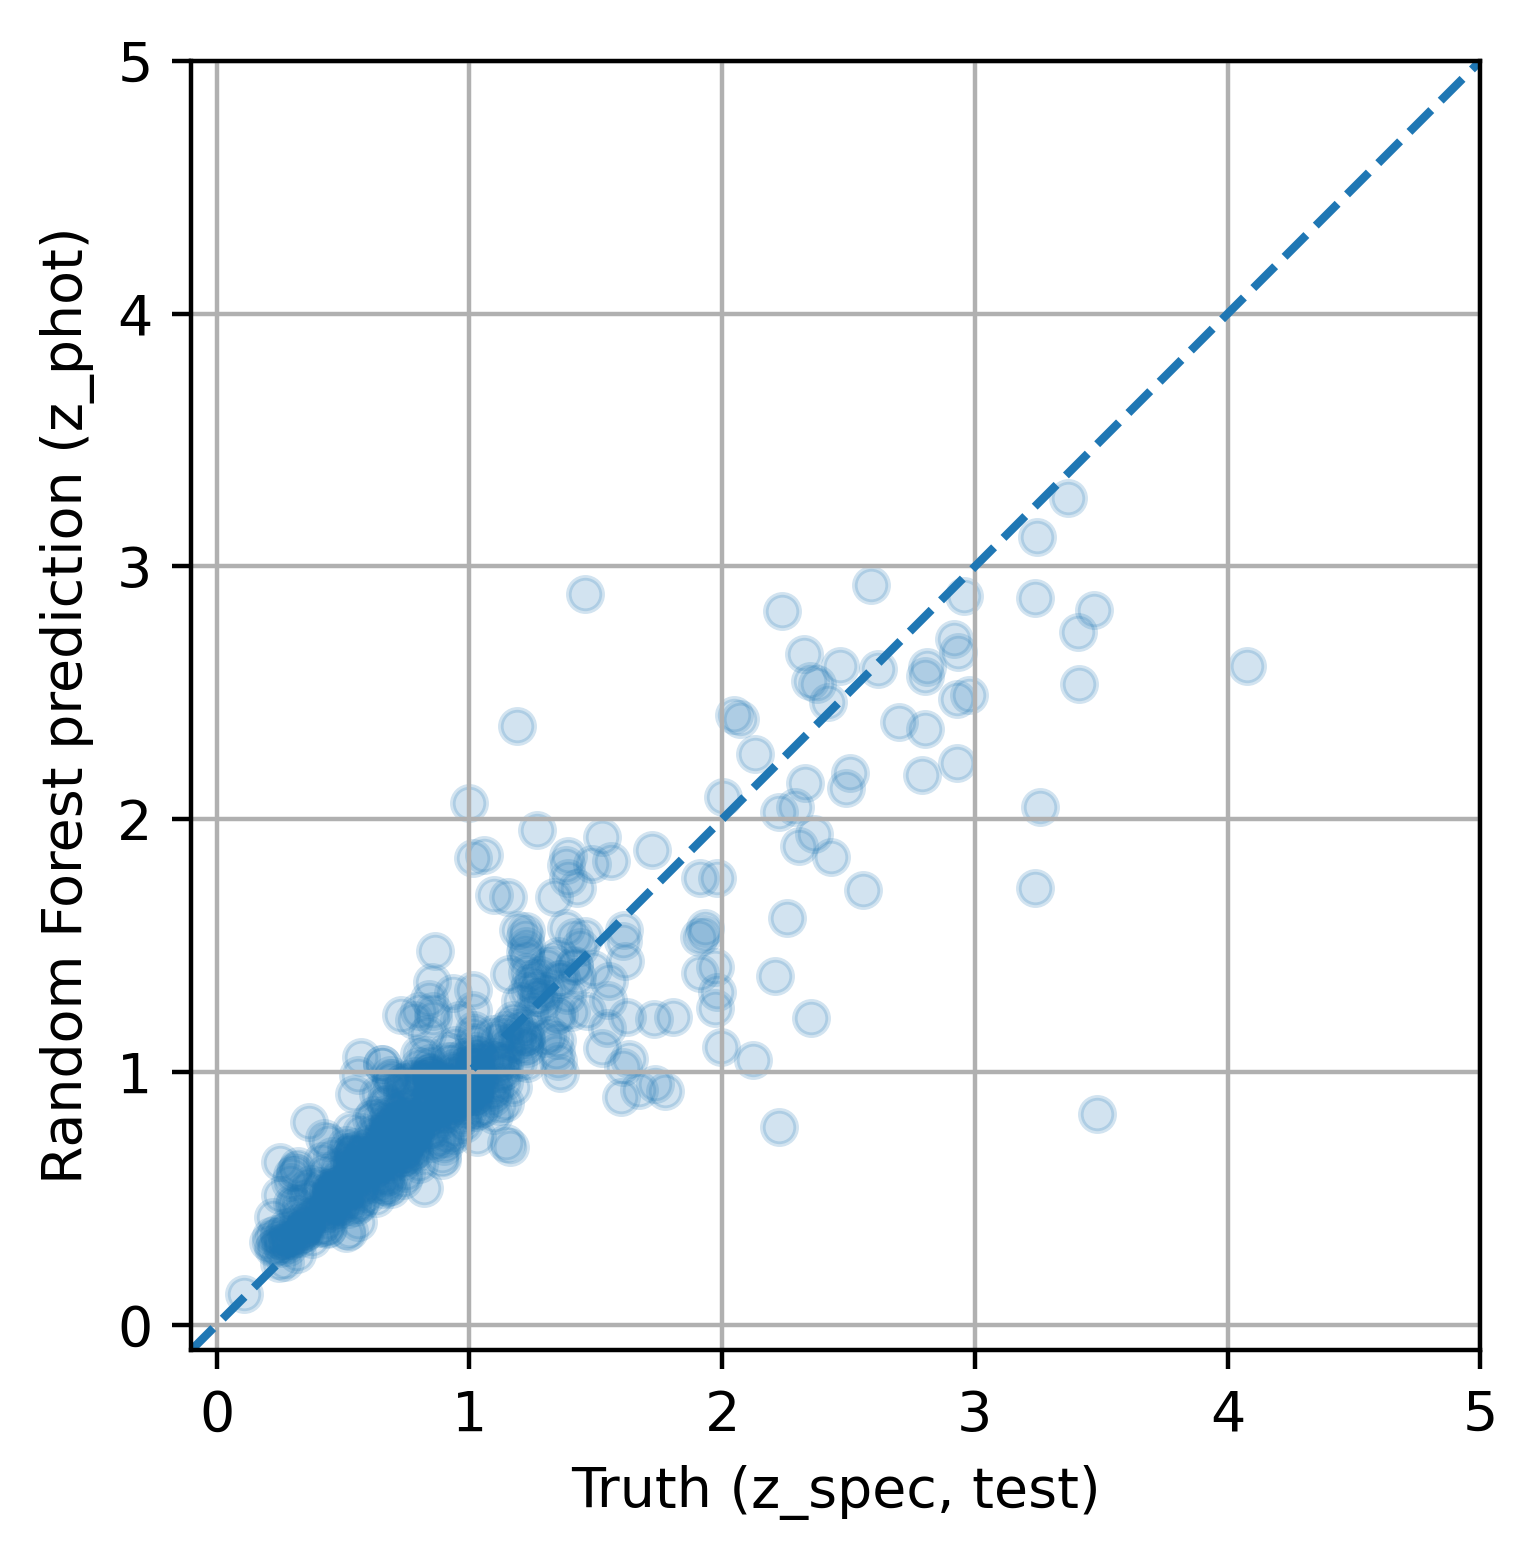

[Validation] Random Forest  MSE: 0.093463 | RMSE: 0.305717
[Validation] EAZY (z_peak)  MSE: 0.134827 | RMSE: 0.367189
[Validation] MSE ratio  (RF/EAZY): 0.693
[Validation] RMSE ratio (RF/EAZY): 0.833


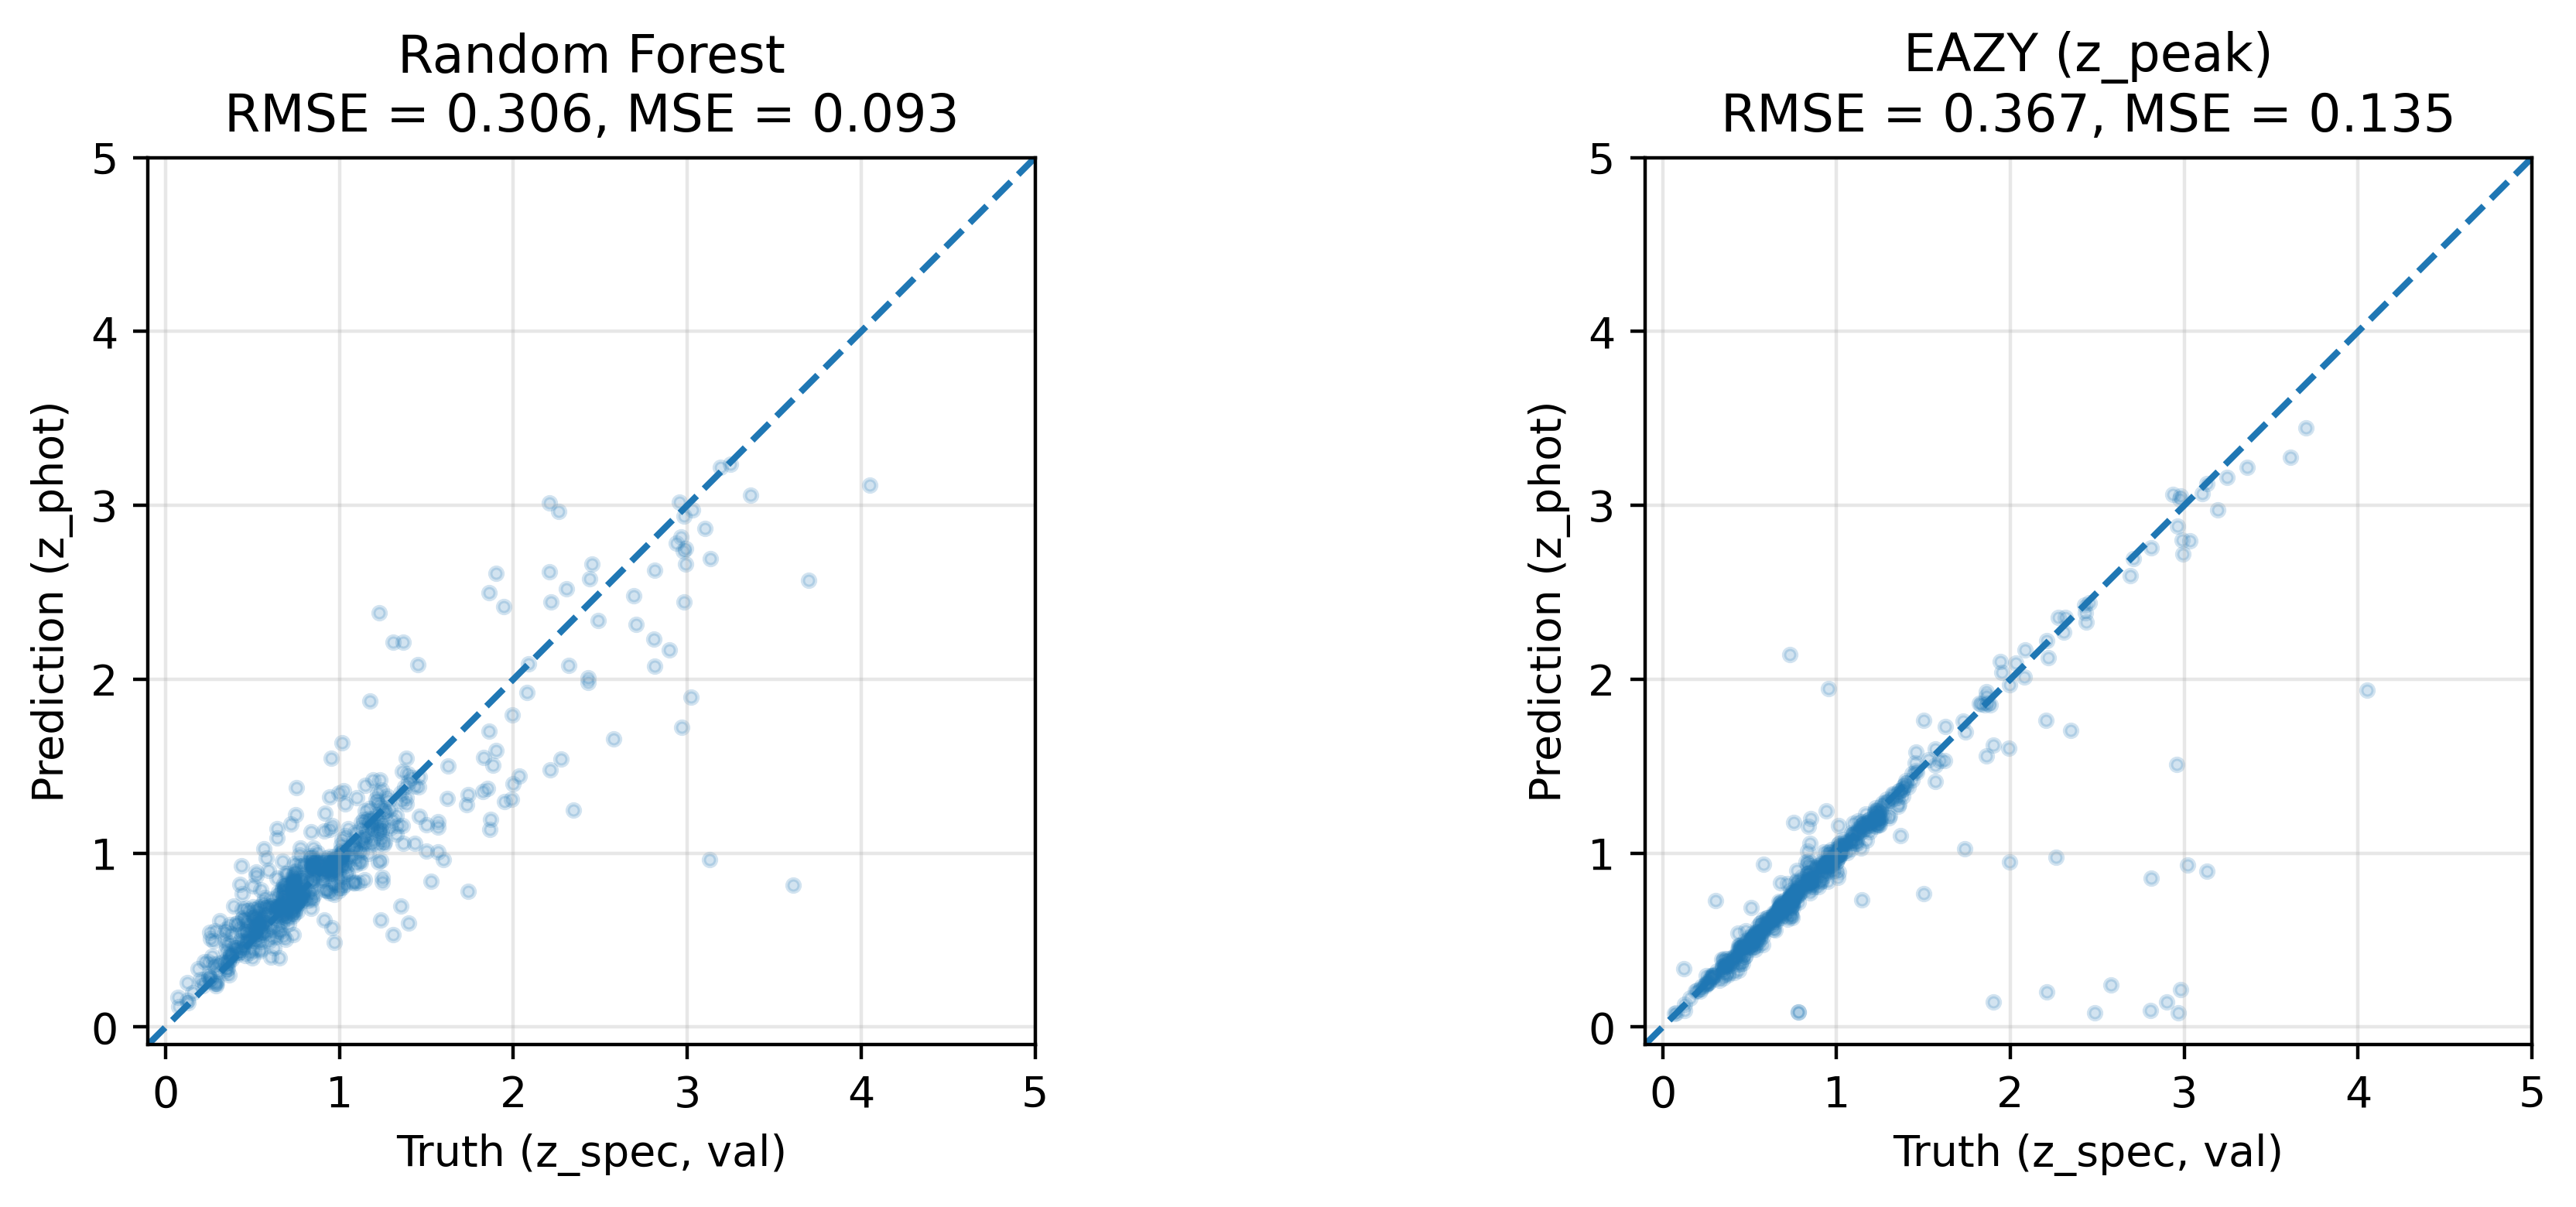

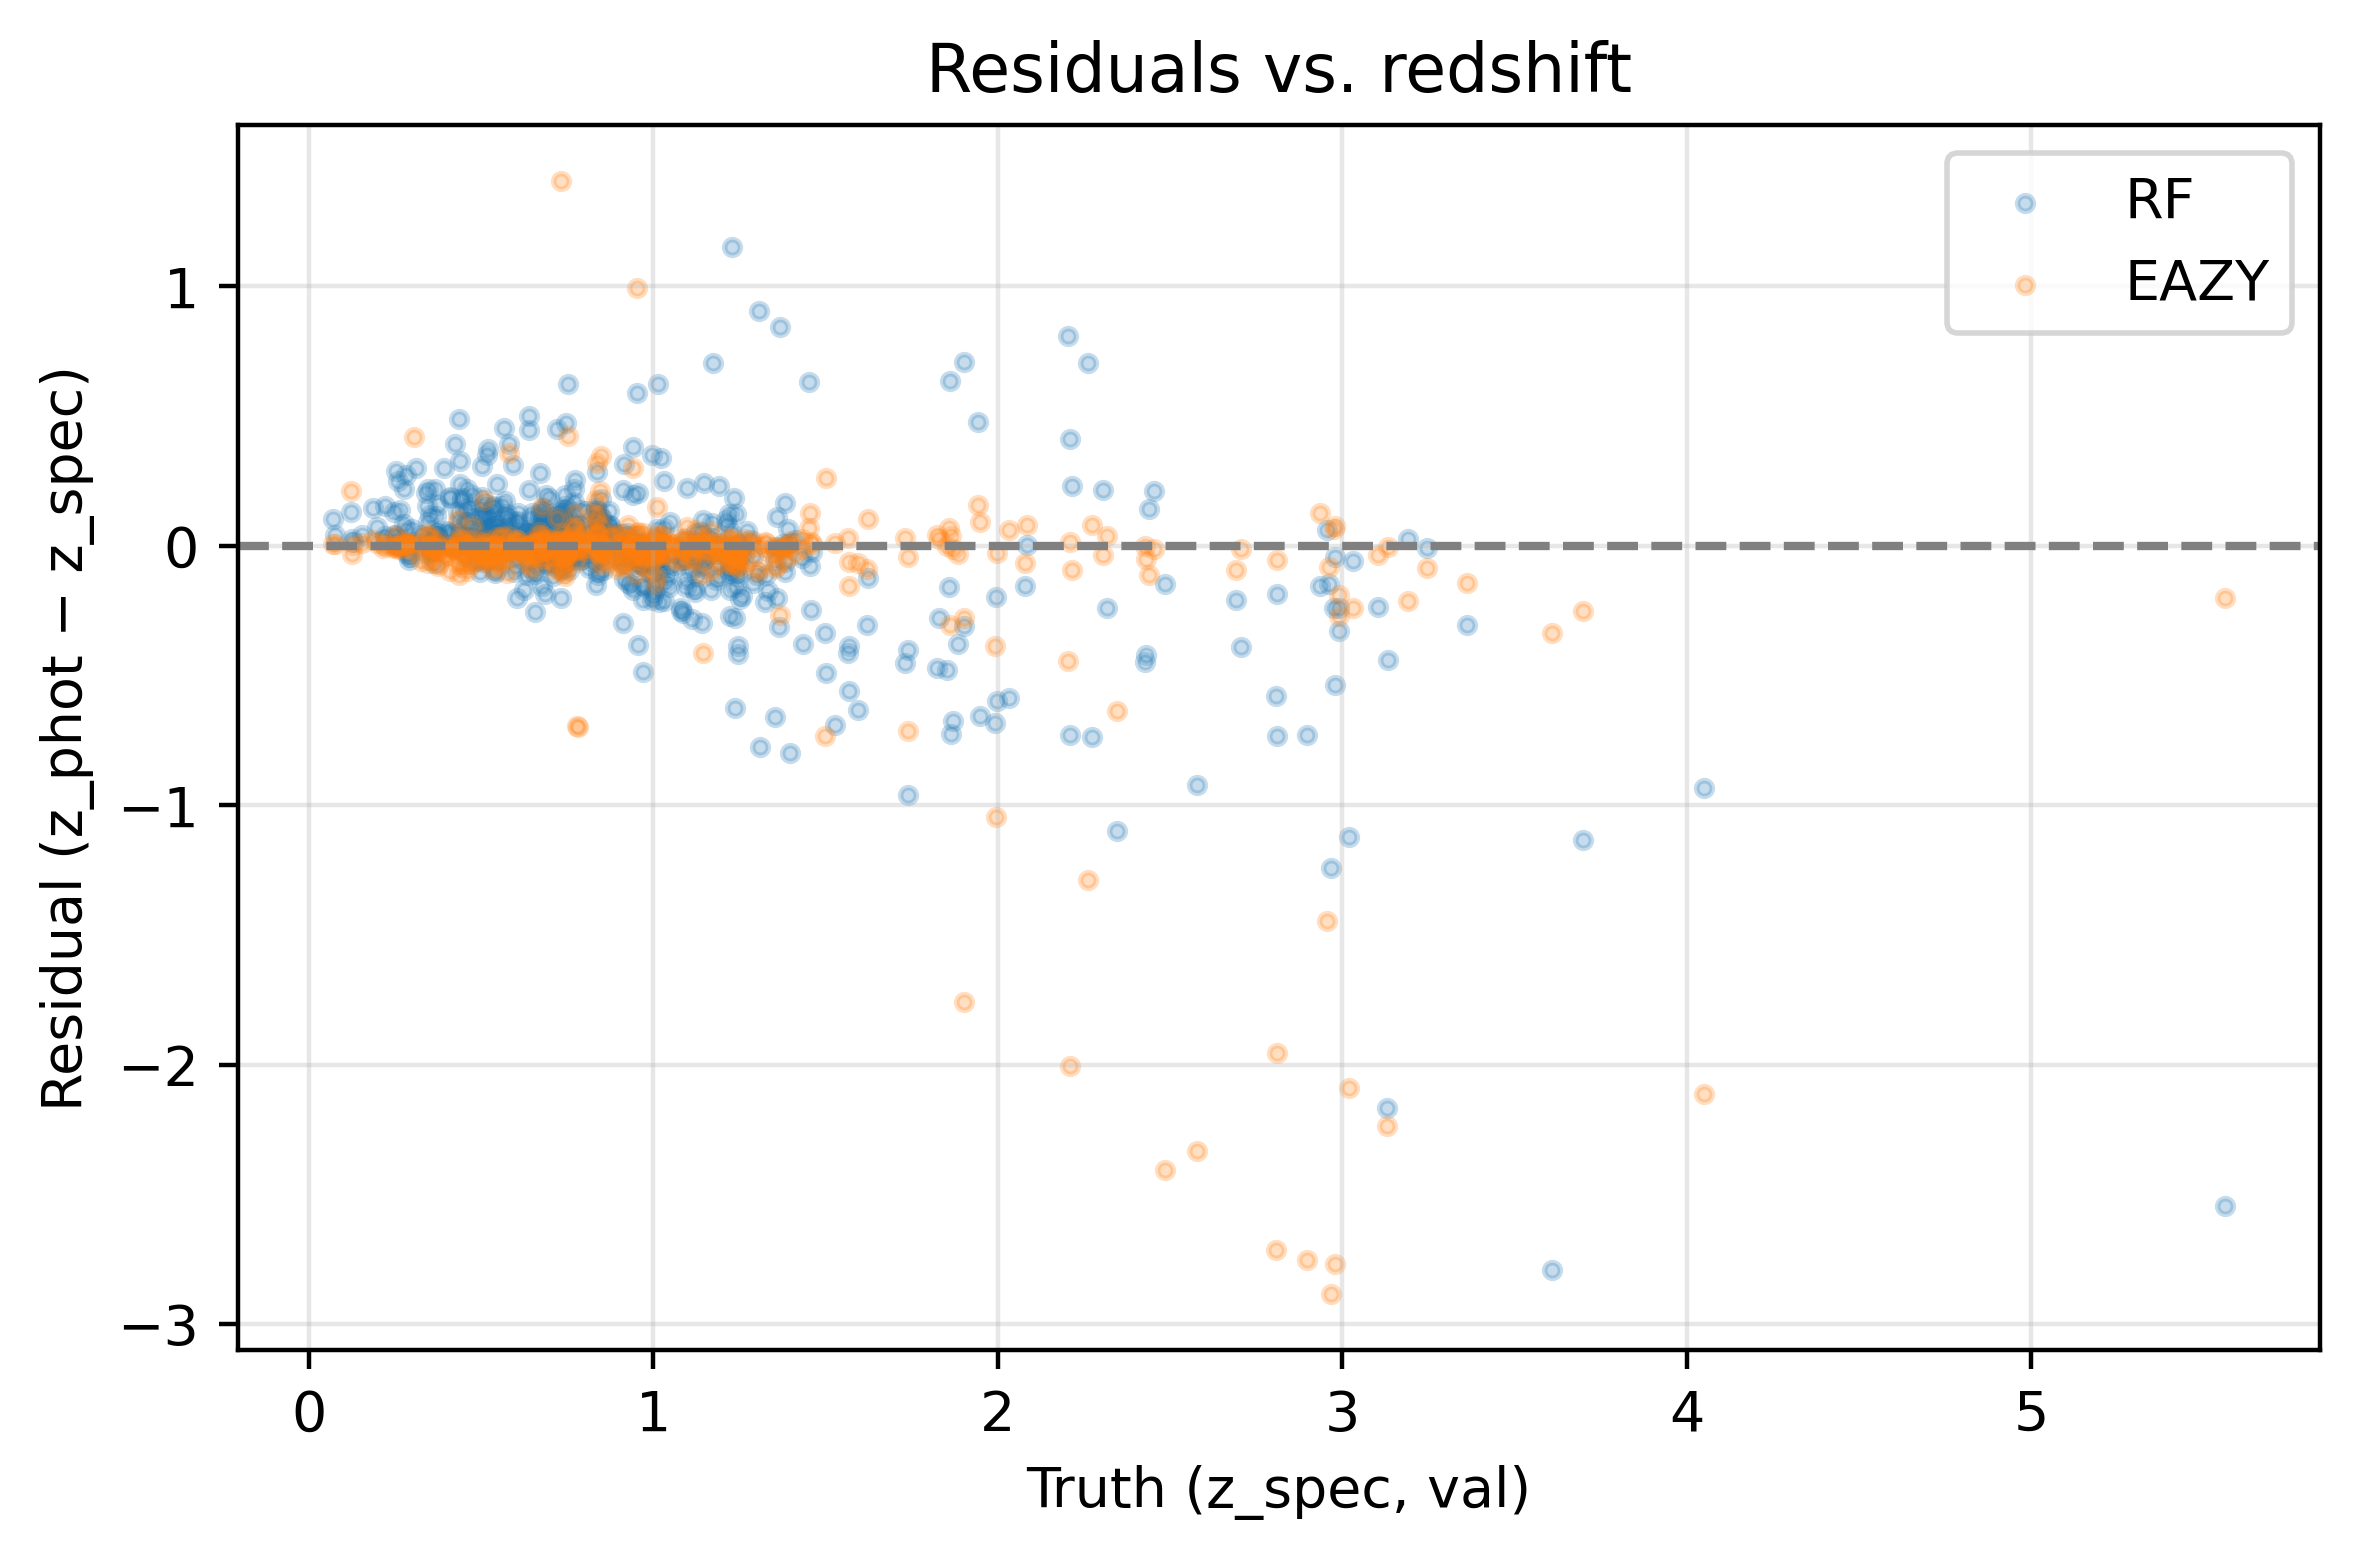

In [14]:
import itertools
import numpy as np
import tarfile
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -------------------------
# Load
# -------------------------
tab = Table.read('/Users/fengbocheng/Projects/Photometric-Redshifts/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat',
                 format='ascii').to_pandas()
target = 'z_spec'

# -------------------------
# 0) Basic quality cuts BEFORE feature engineering
# -------------------------
must_have = {'use_phot', 'z_spec'}
if must_have.issubset(tab.columns):
    mask = (tab['use_phot'] == 1) & (tab[target] > 0)
    if 'lmass' in tab.columns:
        mask &= (tab['lmass'] > 9)
    tab = tab[mask].copy()

# -------------------------
# 1) Clean error columns
# -------------------------
errors = [c for c in tab.columns if (c.startswith('e_') and c.endswith('W')) or c.startswith('eaper_')]
for e in errors:
    tab.loc[(~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90), e] = np.nan

# -------------------------
# 2) Transfer all fluxes to AB magnitudes (zeropoint = 25)
# -------------------------
bands = ['F606W', 'F814W', 'F140W', 'F160W', 'F125W']
for b in bands:
    fcol = f'f_{b}'
    if fcol in tab.columns:
        tab.loc[(~np.isfinite(tab[fcol])) | (tab[fcol] <= 0), fcol] = np.nan
        tab[f'mag_{b}'] = 25.0 - 2.5 * np.log10(np.clip(tab[fcol].to_numpy(), 1e-6, np.inf))

# -------------------------
# 3) Add color features: ALL pairwise colors (no duplicates)
# -------------------------
mag_cols = [f'mag_{b}' for b in bands if f'mag_{b}' in tab.columns]
for a, b in itertools.combinations(mag_cols, 2):
    band_a = a.replace('mag_', '')
    band_b = b.replace('mag_', '')
    tab[f'color_{band_a}_{band_b}'] = tab[a] - tab[b]

# -------------------------
# 4) Add axis ratio b/a (simple morphology)
# -------------------------
if {'a_image', 'b_image'}.issubset(tab.columns):
    tab['axis_ratio'] = tab['b_image'] / (tab['a_image'] + 1e-6)

# -------------------------
# 5) Assemble feature list 
# -------------------------
feature_cols = []
# magnitudes
for b in bands:
    c = f'mag_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# all pairwise colors
for a, b in itertools.combinations([bb for bb in bands if f'mag_{bb}' in tab.columns], 2):
    c = f'color_{a}_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# axis ratio (optional)
if 'axis_ratio' in tab.columns:
    feature_cols.append('axis_ratio')
# other scalar features (only add if present)
for extra in ['flux_radius', 'fwhm_image', 'kron_radius', 'tot_cor']:
    if extra in tab.columns:
        feature_cols.append(extra)

# -------------------------
# 5b) Add S/N features per band (if both flux & error exist)
# -------------------------
for b in bands:
    f = f"f_{b}"
    e = f"e_{b}"
    if f in tab.columns and e in tab.columns:
        sn = f"snr_{b}"
        tab[sn] = np.where((tab[e] > 0) & np.isfinite(tab[e]), tab[f]/tab[e], np.nan)
        if sn not in feature_cols:
            feature_cols.append(sn)

# -------------------------
# Build X (DataFrame) and y
# -------------------------
X = tab[feature_cols]   # DataFrame (keep names for ColumnTransformer)
y = tab[target].values
indices = np.arange(len(y))

# -------------------------
# 6) Stratified splits on binned z_spec
# -------------------------
n_bins = 10  # reduce if you get "least populated class has only 1 member"
quantiles = np.quantile(y, np.linspace(0, 1, n_bins + 1))
quantiles = np.unique(quantiles)
if len(quantiles) < 3:
    quantiles = np.quantile(y, np.linspace(0, 1, 6))  # 5 bins
y_bins_all = np.digitize(y, quantiles[1:-1], right=True)

# 6.1 Train vs temp (val+test)
X_train, X_temp, y_train, y_temp, indices_train, indices_temp, bins_train, bins_temp = train_test_split(
    X, y, indices, y_bins_all,
    test_size=0.30, random_state=42, stratify=y_bins_all
)

# 6.2 Temp → validation & test (50/50), stratified within temp
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(
    X_temp, y_temp, indices_temp,
    test_size=0.50, random_state=42, stratify=bins_temp
)

# -------------------------
# 7) Pipeline (no leakage) + log1p target + tuned RF
# -------------------------
pre = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median", add_indicator=True), feature_cols)],
    remainder="drop",
)

rf_base = RandomForestRegressor(
    random_state=42, n_jobs=-1, bootstrap=True, oob_score=True
)

pipe = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=rf_base, func=np.log1p, inverse_func=np.expm1
    )),
])

# Focused search on the knobs that matter
param_dist = {
    # trees: more is stabler; let the search pick a sweet spot
    "reg__regressor__n_estimators": randint(500, 1201),      # 500–1200
    # depth: you observed plateau ~12; search compact 6–20
    "reg__regressor__max_depth":    randint(6, 21),          # 6–20
    # feature subsampling: 0.2–0.8 often good (plus categorical options)
    "reg__regressor__max_features": uniform(0.2, 0.6),       # continuous 0.2–0.8
    # regularization knobs
    "reg__regressor__min_samples_leaf": randint(1, 9),       # 1–8
    "reg__regressor__min_samples_split": randint(2, 21),     # 2–20
    # bootstrap subsampling per tree to decorrelate trees
    "reg__regressor__max_samples":  uniform(0.5, 0.5),       # 0.5–1.0
}

rf_random = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30, cv=5, scoring="neg_mean_squared_error",
    random_state=42, verbose=1
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print("Best params:", rf_random.best_params_)

# -------------------------
# 8) Evaluate on test set
# -------------------------
y_predict_test = best_rf.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_predict_test))

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=400)
ax.scatter(y_test, y_predict_test, alpha=0.2)
ax.plot([-0.1, 5], [-0.1, 5], linestyle='--')  # 1:1 line
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid(True)
ax.set_xlabel('Truth (z_spec, test)')
ax.set_ylabel('Random Forest prediction (z_phot)')
plt.tight_layout()
plt.show()

# -------------------------
# 9) Validation comparison vs Skelton+2014 z_peak
# -------------------------
z_ml   = best_rf.predict(X_validate)                   # ML (pipeline RF)
z_eazy = tab['z_peak'].to_numpy()[indices_validate]    # EAZY baseline
z_spec = y_validate                                    # ground truth

# MSE / RMSE and ratios (validation)
mse_ml  = mean_squared_error(z_spec, z_ml)
mse_ez  = mean_squared_error(z_spec, z_eazy)
rmse_ml = np.sqrt(mse_ml)
rmse_ez = np.sqrt(mse_ez)

print(f"[Validation] Random Forest  MSE: {mse_ml:.6f} | RMSE: {rmse_ml:.6f}")
print(f"[Validation] EAZY (z_peak)  MSE: {mse_ez:.6f} | RMSE: {rmse_ez:.6f}")
print(f"[Validation] MSE ratio  (RF/EAZY): {mse_ml / mse_ez:.3f}")
print(f"[Validation] RMSE ratio (RF/EAZY): {rmse_ml / rmse_ez:.3f}")

# Scatter: predictions vs. z_spec (RF & EAZY)
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)

ax[0].scatter(z_spec, z_ml, alpha=0.2, s=8)
ax[0].plot([-0.1, 5], [-0.1, 5], ls='--')
ax[0].set_aspect('equal'); ax[0].set_xlim(-0.1, 5); ax[0].set_ylim(-0.1, 5)
ax[0].grid(True, alpha=0.3)
ax[0].set_xlabel('Truth (z_spec, val)')
ax[0].set_ylabel('Prediction (z_phot)')
ax[0].set_title(f'Random Forest\nRMSE = {rmse_ml:.3f}, MSE = {mse_ml:.3f}')

ax[1].scatter(z_spec, z_eazy, alpha=0.2, s=8)
ax[1].plot([-0.1, 5], [-0.1, 5], ls='--')
ax[1].set_aspect('equal'); ax[1].set_xlim(-0.1, 5); ax[1].set_ylim(-0.1, 5)
ax[1].grid(True, alpha=0.3)
ax[1].set_xlabel('Truth (z_spec, val)')
ax[1].set_ylabel('Prediction (z_phot)')
ax[1].set_title(f'EAZY (z_peak)\nRMSE = {rmse_ez:.3f}, MSE = {mse_ez:.3f}')

plt.tight_layout()
plt.show()

# Residuals vs z_spec
res_rf = z_ml - z_spec
res_ez = z_eazy - z_spec

fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
ax.scatter(z_spec, res_rf, alpha=0.25, s=8, label='RF')
ax.scatter(z_spec, res_ez, alpha=0.25, s=8, label='EAZY')
ax.axhline(0, color='gray', ls='--')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Truth (z_spec, val)')
ax.set_ylabel('Residual (z_phot − z_spec)')
ax.set_title('Residuals vs. redshift')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import itertools
import numpy as np
import tarfile
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -------------------------
# Load
# -------------------------
tab = Table.read(
    '/Users/fengbocheng/Projects/Photometric-Redshifts/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat',
    format='ascii'
).to_pandas()

target = 'z_spec'

# -------------------------
# 0) Basic quality cuts BEFORE feature engineering
# -------------------------
must_have = {'use_phot', 'z_spec'}
if must_have.issubset(tab.columns):
    mask = (tab['use_phot'] == 1) & (tab[target] > 0)
    if 'lmass' in tab.columns:
        mask &= (tab['lmass'] > 9)
    tab = tab[mask].copy()

# -------------------------
# 1) Clean error columns
# -------------------------
errors = [c for c in tab.columns if (c.startswith('e_') and c.endswith('W')) or c.startswith('eaper_')]
for e in errors:
    tab.loc[(~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90), e] = np.nan

# -------------------------
# 2) Fluxes → AB magnitudes (zeropoint = 25)
# -------------------------
bands = ['F606W', 'F814W', 'F140W', 'F160W', 'F125W']
for b in bands:
    fcol = f'f_{b}'
    if fcol in tab.columns:
        tab.loc[(~np.isfinite(tab[fcol])) | (tab[fcol] <= 0), fcol] = np.nan
        tab[f'mag_{b}'] = 25.0 - 2.5 * np.log10(np.clip(tab[fcol].to_numpy(), 1e-6, np.inf))

# -------------------------
# 3) Add pairwise colors
# -------------------------
mag_cols = [f'mag_{b}' for b in bands if f'mag_{b}' in tab.columns]
for a, b in itertools.combinations(mag_cols, 2):
    band_a = a.replace('mag_', '')
    band_b = b.replace('mag_', '')
    tab[f'color_{band_a}_{band_b}'] = tab[a] - tab[b]

# -------------------------
# 4) Axis ratio b/a (simple morphology)
# -------------------------
if {'a_image', 'b_image'}.issubset(tab.columns):
    tab['axis_ratio'] = tab['b_image'] / (tab['a_image'] + 1e-6)

# -------------------------
# 5) Feature list
# -------------------------
feature_cols = []
# magnitudes
for b in bands:
    c = f'mag_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# pairwise colors
for a, b in itertools.combinations([bb for bb in bands if f'mag_{bb}' in tab.columns], 2):
    c = f'color_{a}_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# axis ratio (optional)
if 'axis_ratio' in tab.columns:
    feature_cols.append('axis_ratio')
# other scalar features (only if present)
for extra in ['flux_radius', 'fwhm_image', 'kron_radius', 'tot_cor']:
    if extra in tab.columns:
        feature_cols.append(extra)

# S/N per band (if both flux & error exist)
for b in bands:
    f = f"f_{b}"
    e = f"e_{b}"
    if f in tab.columns and e in tab.columns:
        sn = f"snr_{b}"
        tab[sn] = np.where((tab[e] > 0) & np.isfinite(tab[e]), tab[f]/tab[e], np.nan)
        if sn not in feature_cols:
            feature_cols.append(sn)

# -------------------------
# Build X and y
# -------------------------
X = tab[feature_cols]
y = tab[target].values
indices = np.arange(len(y))

# -------------------------
# 6) Stratified splits on binned z_spec
# -------------------------
n_bins = 10
quantiles = np.quantile(y, np.linspace(0, 1, n_bins + 1))
quantiles = np.unique(quantiles)
if len(quantiles) < 3:
    quantiles = np.quantile(y, np.linspace(0, 1, 6))  # fallback 5 bins
y_bins_all = np.digitize(y, quantiles[1:-1], right=True)

# 6.1 Train vs temp (val+test)
X_train, X_temp, y_train, y_temp, indices_train, indices_temp, bins_train, bins_temp = train_test_split(
    X, y, indices, y_bins_all,
    test_size=0.30, random_state=42, stratify=y_bins_all
)

# 6.2 Temp → validation & test (50/50), stratified within temp
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(
    X_temp, y_temp, indices_temp,
    test_size=0.50, random_state=42, stratify=bins_temp
)
print(len(X_test))
# -------------------------
# 7) Pipeline (no leakage) + log1p target + tuned RF
# -------------------------
pre = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median", add_indicator=True), feature_cols)],
    remainder="drop",
)

rf_base = RandomForestRegressor(
    random_state=42, n_jobs=-1, bootstrap=True, oob_score=True
)

pipe = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=rf_base, func=np.log1p, inverse_func=np.expm1
    )),
])

param_dist = {
    "reg__regressor__n_estimators": randint(500, 1201),
    "reg__regressor__max_depth":    randint(6, 21),
    "reg__regressor__max_features": uniform(0.2, 0.6),
    "reg__regressor__min_samples_leaf": randint(1, 9),
    "reg__regressor__min_samples_split": randint(2, 21),
    "reg__regressor__max_samples":  uniform(0.5, 0.5),
}

rf_random = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30, cv=5, scoring="neg_mean_squared_error",
    random_state=42, verbose=1
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print("Best params:", rf_random.best_params_)

# -------------------------
# 8) Evaluate on test set (MSE just for reference)
# -------------------------
z_rf_test   = best_rf.predict(X_test)
z_eazy_test = tab['z_peak'].to_numpy()[indices_test]
z_spec_test = y_test

mse_rf_test = mean_squared_error(z_spec_test, z_rf_test)
mse_ez_test = mean_squared_error(z_spec_test, z_eazy_test)
print(f"[Test] RF    MSE: {mse_rf_test:.6f}")
print(f"[Test] EAZY  MSE: {mse_ez_test:.6f}")

# -------------------------
# 9) Figure: two columns (RF vs EAZY), each with a residual sub-panel
# -------------------------
res_rf_test   = z_rf_test   - z_spec_test
res_ez_test   = z_eazy_test - z_spec_test

zmin, zmax = -0.1, 5.0
res_ylim   = (-0.5, 0.5)  # adjust to your data spread

fig = plt.figure(figsize=(10, 6), dpi=400)
gs  = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[3, 1], hspace=0.05, wspace=0.15)

# ---- LEFT: Random Forest ----
ax_main_rf = fig.add_subplot(gs[0, 0])
ax_res_rf  = fig.add_subplot(gs[1, 0], sharex=ax_main_rf)

ax_main_rf.scatter(z_spec_test, z_rf_test, alpha=0.25, s=8)
ax_main_rf.plot([zmin, zmax], [zmin, zmax], ls='--')
ax_main_rf.set_xlim(zmin, zmax)
ax_main_rf.set_ylim(zmin, zmax)
ax_main_rf.set_aspect('equal')
ax_main_rf.grid(True, alpha=0.3)
ax_main_rf.set_ylabel('Prediction (z_phot)')
ax_main_rf.set_title(f'Random Forest (test) | MSE={mse_rf_test:.3f}')

ax_res_rf.scatter(z_spec_test, res_rf_test, alpha=0.25, s=8)
ax_res_rf.axhline(0, ls='--')
ax_res_rf.set_ylim(res_ylim)
ax_res_rf.grid(True, alpha=0.3)
ax_res_rf.set_xlabel('Truth (z_spec, test)')
ax_res_rf.set_ylabel('Residual')

# ---- RIGHT: EAZY (z_peak) ----
ax_main_ez = fig.add_subplot(gs[0, 1])
ax_res_ez  = fig.add_subplot(gs[1, 1], sharex=ax_main_ez)

ax_main_ez.scatter(z_spec_test, z_eazy_test, alpha=0.25, s=8)
ax_main_ez.plot([zmin, zmax], [zmin, zmax], ls='--')
ax_main_ez.set_xlim(zmin, zmax)
ax_main_ez.set_ylim(zmin, zmax)
ax_main_ez.set_aspect('equal')
ax_main_ez.grid(True, alpha=0.3)
ax_main_ez.set_title(f'EAZY (z_peak, test) | MSE={mse_ez_test:.3f}')

ax_res_ez.scatter(z_spec_test, res_ez_test, alpha=0.25, s=8)
ax_res_ez.axhline(0, ls='--')
ax_res_ez.set_ylim(res_ylim)
ax_res_ez.grid(True, alpha=0.3)
ax_res_ez.set_xlabel('Truth (z_spec, test)')

# Tidy shared x tick labels for top row
plt.setp(ax_main_rf.get_xticklabels(), visible=False)
plt.setp(ax_main_ez.get_xticklabels(), visible=False)

plt.tight_layout()
plt.show()


=== AEGIS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
AEGIS: RF MSE=0.01030  |  EAZY MSE=0.02246 (n_eazy=329)

=== COSMOS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
COSMOS: RF MSE=0.00240  |  EAZY MSE=0.00345 (n_eazy=126)

=== GOODS-S ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
GOODS-S: RF MSE=0.09000  |  EAZY MSE=0.12040 (n_eazy=384)

=== GOODS-N ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
GOODS-N: RF MSE=0.11630  |  EAZY MSE=0.11567 (n_eazy=551)

=== UDS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
UDS: RF MSE=0.04284  |  EAZY MSE=0.15607 (n_eazy=53)


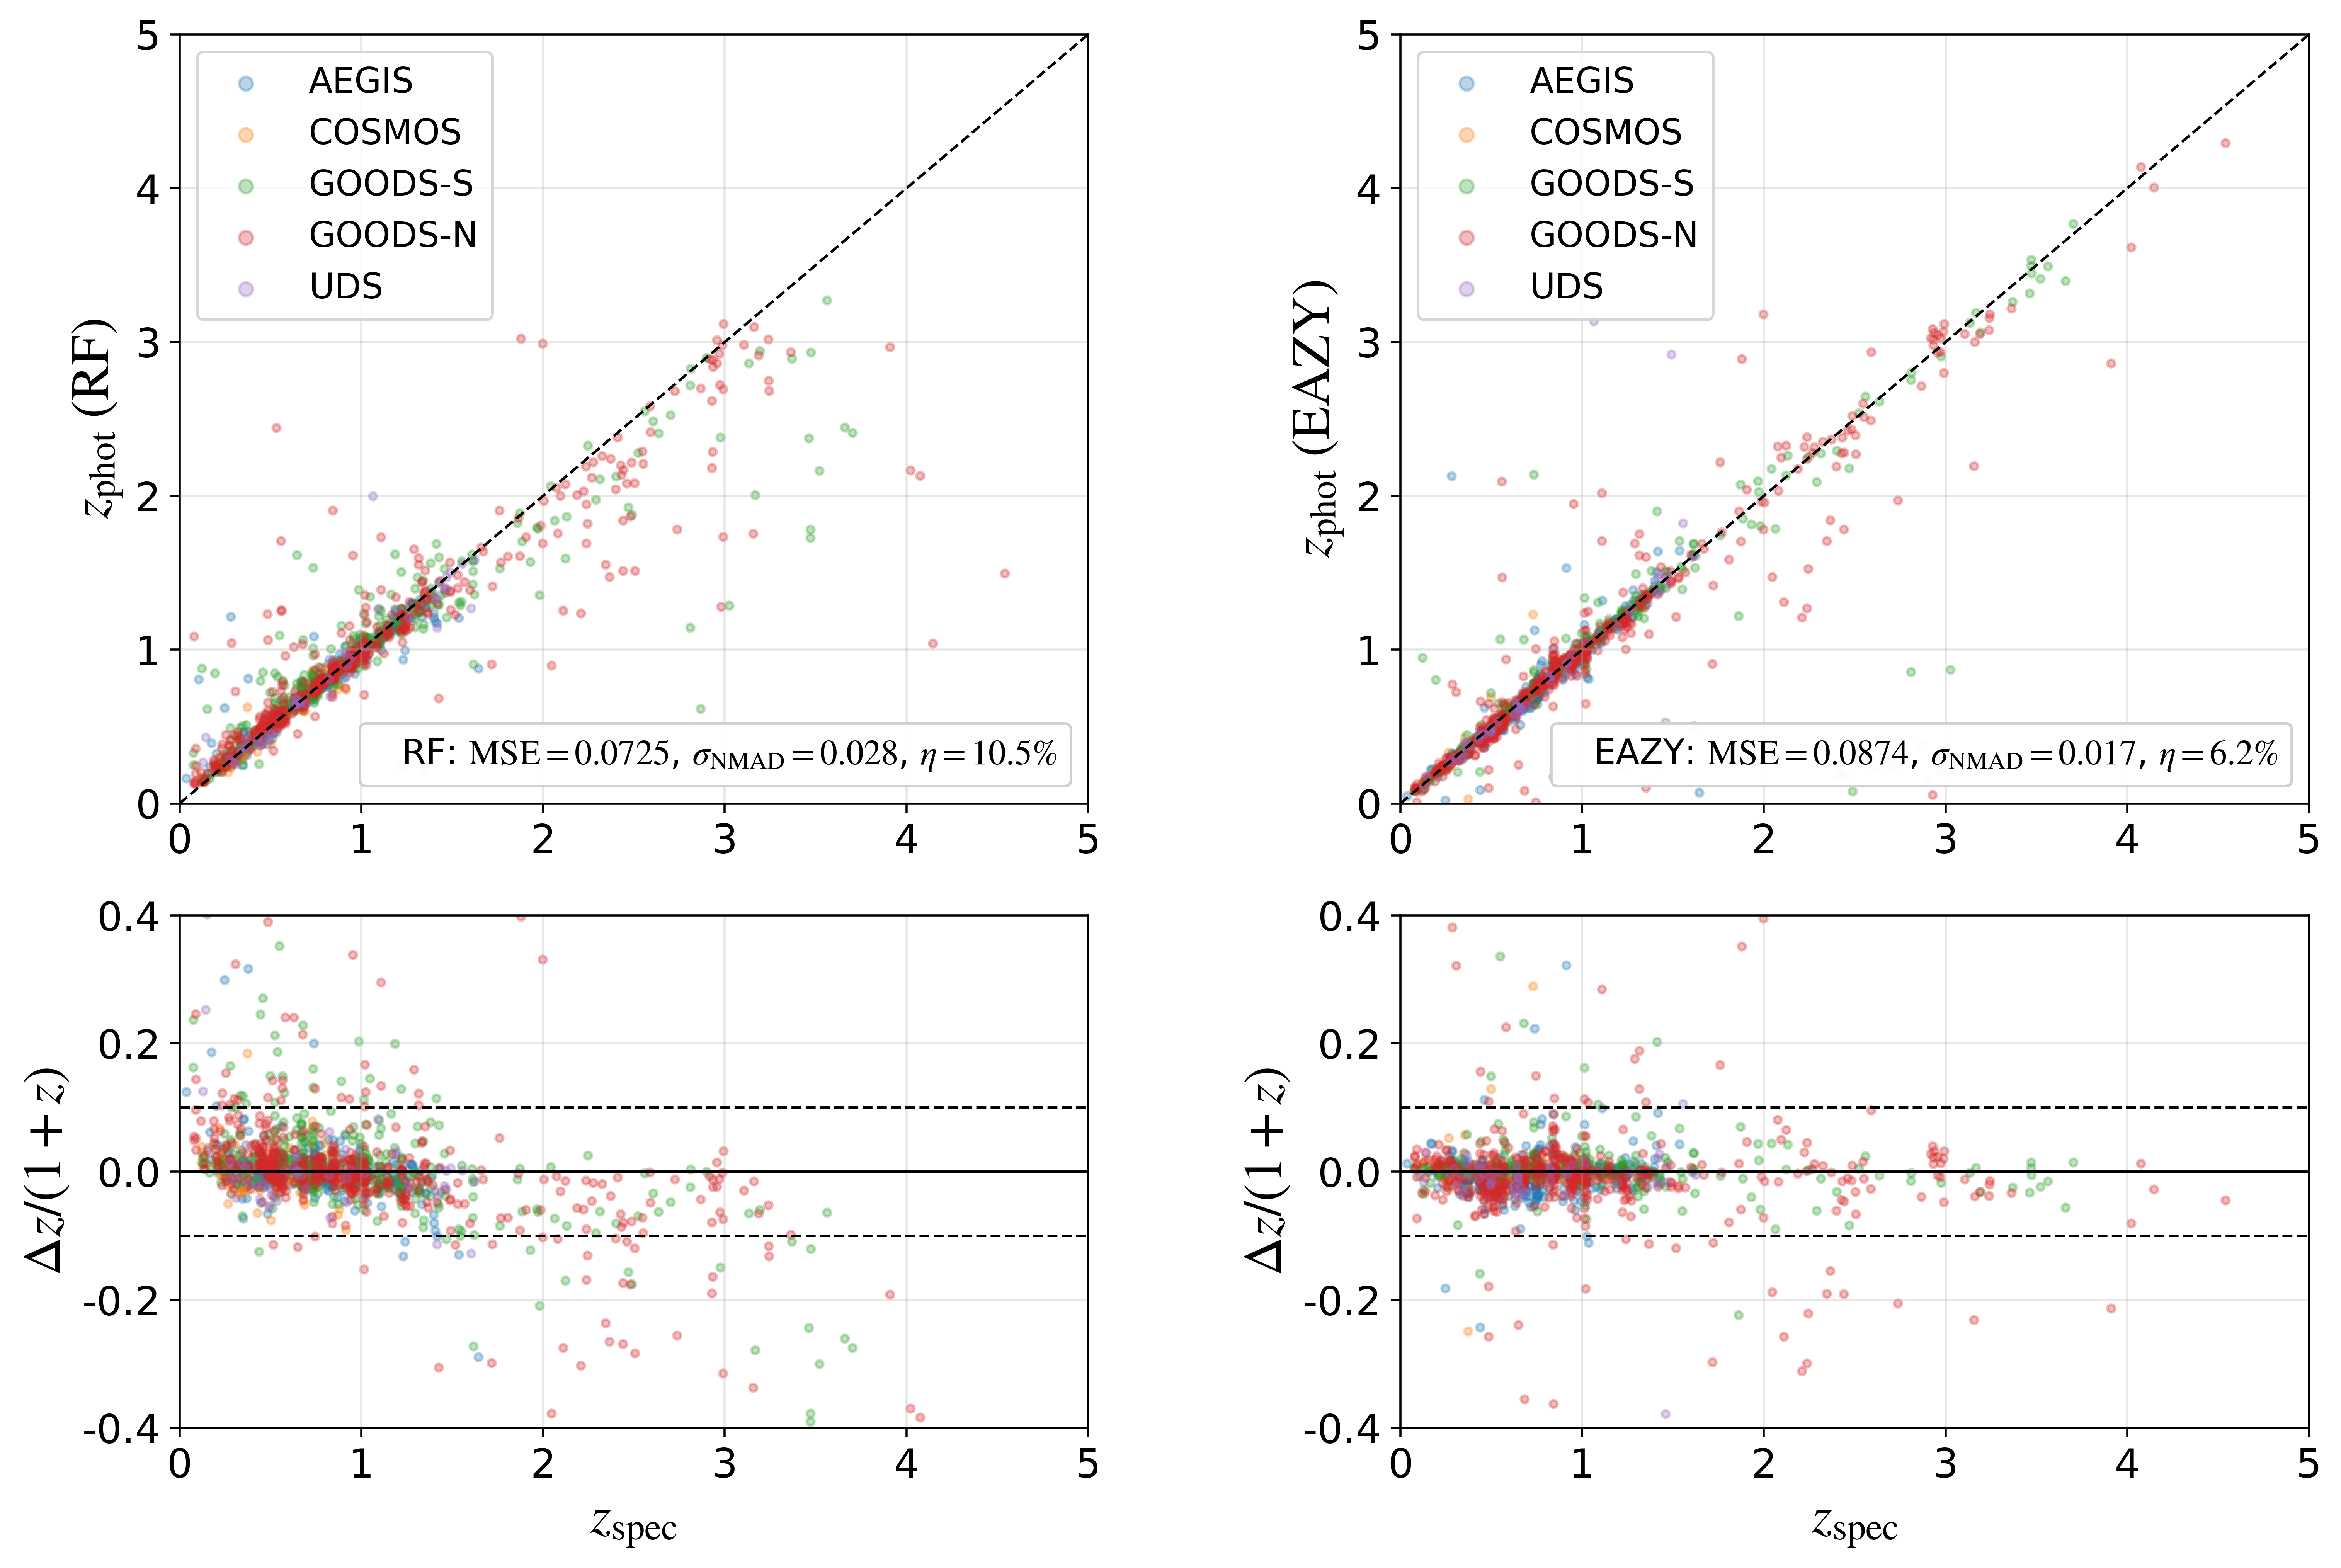


Per-field summary:
  field  n_test  mse_rf  mse_eazy  n_eazy
  AEGIS     329 0.01030   0.02246     329
 COSMOS     126 0.00240   0.00345     126
GOODS-N     551 0.11630   0.11567     551
GOODS-S     384 0.09000   0.12040     384
    UDS      53 0.04284   0.15607      53

Global (all fields, test sets combined):
RF   -> MSE(z)=0.07249, NMAD=0.0283, η=10.53%
EAZY -> MSE(z)=0.08736, NMAD=0.0175, η=6.17%


In [17]:

import os
import itertools
import numpy as np
import pandas as pd
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

# -------------------------
# Paths (EDIT THESE)
# -------------------------
BASE = "/Users/fengbocheng/Projects/Photometric-Redshifts"

FIELDS = {
    "AEGIS": {
        "cat":  f"{BASE}/aegis_3dhst.v4.1.cats/Catalog/aegis_3dhst.v4.1.cat",
        "zout": f"{BASE}/aegis_3dhst.v4.1.cats/Eazy/aegis_3dhst.v4.1.zout",
        "bands": [
            "U","G","F606W","R","I","F814W","Z",
            "F125W","J1","J2","J3","J","F140W","H1","H2","H","K","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "COSMOS": {
        "cat":  f"{BASE}/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat",
        "zout": f"{BASE}/cosmos_3dhst.v4.1.cats/Eazy/cosmos_3dhst.v4.1.zout",
        "bands": [
            "U","B","G","V","F606W","R","Rp","I","Ip","F814W","Z","Zp",
            "UVISTA_Y","F125W","J1","J2","J3","J","UVISTA_J","F140W",
            "H1","H2","H","UVISTA_H","K","Ks","UVISTA_Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "GOODS-S": {
        "cat":  f"{BASE}/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat",
        "zout": f"{BASE}/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout",
        "bands": [
            "U38","U","F435W","B","V","F606W","R","Rc","F775W","I","F814W","F850LP",
            "F125W","J","F140W","H","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "GOODS-N": {
        "cat":  f"{BASE}/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat",
        "zout": f"{BASE}/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout",
        "bands": [
            "U","F435W","B","G","V","F606W","R","Rs","I","F775W","Z","F850LP",
            "F125W","J","F140W","H","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "UDS": {
        "cat":  f"{BASE}/uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat",
        "zout": f"{BASE}/uds_3dhst.v4.2.cats/Eazy/uds_3dhst.v4.2.zout",
        "bands": [
            "u","B","V","F606W","R","i","F814W","z",
            "F125W","J","F140W","H","K",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
}

# -------------------------
# Config
# -------------------------
TARGET_COL        = "z_spec"
MAG_ZP            = 25.0
FLUX_FLOOR        = 1e-6
INCLUDE_COLORS    = True
N_BINS_STRAT      = 8  # for stratified split
PLOT_BINS         = 12 # for metric-vs-z plots
OUTLIER_THR       = 0.10  # |Δz|/(1+z) threshold

# Colors for plotting
PALETTE = {"AEGIS":"C0", "COSMOS":"C1", "GOODS-S":"C2", "GOODS-N":"C3", "UDS":"C4"}

# -------------------------
# Helpers
# -------------------------
def flux_to_mag(flux, zp=MAG_ZP):
    f = np.asarray(flux)
    f = np.where(np.isfinite(f) & (f > 0), f, np.nan)
    f = np.clip(f, FLUX_FLOOR, np.inf)
    return zp - 2.5*np.log10(f)

def build_features_in_bulk(tab: pd.DataFrame, bands: list, include_colors=True) -> pd.DataFrame:
    new_cols = {}
    # magnitudes
    for b in bands:
        fcol = f"f_{b}"
        if fcol in tab.columns:
            new_cols[f"mag_{b}"] = flux_to_mag(tab[fcol].to_numpy())
    # colors
    if include_colors:
        for a, b in itertools.combinations(bands, 2):
            ca, cb = f"mag_{a}", f"mag_{b}"
            if ca in new_cols and cb in new_cols:
                new_cols[f"color_{a}_{b}"] = new_cols[ca] - new_cols[cb]
            elif (ca in tab.columns) and (cb in tab.columns):
                new_cols[f"color_{a}_{b}"] = tab[ca] - tab[cb]
    # S/N
    for b in bands:
        f, e = f"f_{b}", f"e_{b}"
        if (f in tab.columns) and (e in tab.columns):
            earr = tab[e].to_numpy(); farr = tab[f].to_numpy()
            snr = np.where((earr > 0) & np.isfinite(earr) & np.isfinite(farr), farr / earr, np.nan)
            new_cols[f"snr_{b}"] = snr
    if new_cols:
        feat_df = pd.DataFrame(new_cols, index=tab.index)
        return pd.concat([tab, feat_df], axis=1).copy()
    return tab.copy()

def stratified_train_test_indices(y: np.ndarray, test_size=0.3, n_bins=10, seed=42):
    idx = np.where(np.isfinite(y))[0]
    yv = y[idx]
    q = np.quantile(yv, np.linspace(0, 1, n_bins+1))
    q = np.unique(q)
    if len(q) < 3:
        q = np.quantile(yv, np.linspace(0, 1, 6))
    bins = np.digitize(yv, q[1:-1], right=True)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    tr_rel, te_rel = next(sss.split(np.zeros_like(yv), bins))
    return idx[tr_rel], idx[te_rel]

def build_pipeline(feature_cols):
    preproc = ColumnTransformer(
        transformers=[("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ]), feature_cols)],
        remainder="drop",
    )
    rf = RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True, oob_score=False)
    pipe = Pipeline(steps=[("pre", preproc), ("rf", rf)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
    return model

def tuner():
    return {
        "regressor__rf__n_estimators": randint(300, 601),
        "regressor__rf__max_depth":    randint(6, 15),
        "regressor__rf__max_features": uniform(0.2, 0.6),
        "regressor__rf__min_samples_leaf": randint(1, 9),
        "regressor__rf__min_samples_split": randint(2, 21),
        "regressor__rf__max_samples":  uniform(0.6, 0.4),
    }

def nmad(delta):
    """NMAD of array (ignore NaNs)."""
    d = delta[np.isfinite(delta)]
    if d.size == 0:
        return np.nan
    med = np.median(d)
    return 1.4826 * np.median(np.abs(d - med))

def outlier_fraction(delta, thr=OUTLIER_THR):
    d = delta[np.isfinite(delta)]
    if d.size == 0:
        return np.nan
    return np.mean(np.abs(d) > thr)

def binned_metrics(zspec, zpred, nbins=12, zmin=None, zmax=None):
    """Return per-bin metrics: centers, MSE(z), NMAD(norm), outlier_frac(norm)."""
    zspec = np.asarray(zspec)
    zpred = np.asarray(zpred)
    mask = np.isfinite(zspec) & np.isfinite(zpred)
    zspec = zspec[mask]; zpred = zpred[mask]
    if zspec.size == 0:
        edges = np.linspace(0, 1, nbins+1)
        centers = 0.5*(edges[:-1]+edges[1:])
        arr = np.full(nbins, np.nan)
        return centers, arr, arr, arr

    if zmin is None: zmin = np.nanmin(zspec)
    if zmax is None: zmax = np.nanmax(zspec)
    edges = np.linspace(zmin, zmax, nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    mse_b, nmad_b, out_b = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (zspec >= lo) & (zspec < hi)
        if not np.any(m):
            mse_b.append(np.nan); nmad_b.append(np.nan); out_b.append(np.nan)
            continue
        dz   = zpred[m] - zspec[m]
        dzn  = dz / (1.0 + zspec[m])
        mse_b.append(mean_squared_error(zspec[m], zpred[m]))
        nmad_b.append(nmad(dzn))
        out_b.append(outlier_fraction(dzn, thr=OUTLIER_THR))
    return centers, np.array(mse_b), np.array(nmad_b), np.array(out_b)

from sklearn.metrics import make_scorer

def nmad_from_resid(d):
    d = d[np.isfinite(d)]
    if d.size == 0:
        return np.nan
    med = np.median(d)
    return 1.4826 * np.median(np.abs(d - med))

def nmad_scorer_func(y_true, y_pred):
    # normalized residuals
    dzn = (y_pred - y_true) / (1.0 + y_true)
    val = nmad_from_resid(dzn)
    # RandomizedSearchCV maximizes the score; return negative so "smaller NMAD is better"
    return -val if np.isfinite(val) else -1e9  # harsh penalty if undefined

NMAD_SCORER = make_scorer(nmad_scorer_func, greater_is_better=True)

# -------------------------
# Main loop over fields
# -------------------------
all_points_rf   = []  # (field, z_spec_test, z_pred_rf)
all_points_eazy = []  # (field, z_spec_test_for_ez, z_eazy_test)
metrics = []          # per-field numeric summary
all_rf_zspec, all_rf_pred = [], []
all_ez_zspec, all_ez_pred = [], []

for field_name, cfg in FIELDS.items():
    print(f"\n=== {field_name} ===")

    tab  = Table.read(cfg["cat"],  format="ascii").to_pandas()
    zout = Table.read(cfg["zout"], format="ascii").to_pandas()[["id", "z_peak"]]

    if "id" not in tab.columns:
        raise ValueError(f"{field_name}: photometric catalog missing 'id'.")
    tab = tab.merge(zout, on="id", how="left")

    use_col = cfg.get("use_col", "use_phot")
    if use_col in tab.columns:
        tab = tab[tab[use_col] == 1].copy()

    if TARGET_COL not in tab.columns:
        raise ValueError(f"{field_name}: missing {TARGET_COL}.")
    tab = tab[np.isfinite(tab[TARGET_COL]) & (tab[TARGET_COL] > 0)].copy()

    for b in cfg["bands"]:
        e = f"e_{b}"
        if e in tab.columns:
            bad = (~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90)
            tab.loc[bad, e] = np.nan

    tab = build_features_in_bulk(tab, cfg["bands"], include_colors=INCLUDE_COLORS)
    feature_cols = [c for c in tab.columns if c.startswith(("mag_", "color_", "snr_"))]

    y_all = tab[TARGET_COL].to_numpy()
    tr_idx, te_idx = stratified_train_test_indices(y_all, test_size=0.3, n_bins=N_BINS_STRAT, seed=42)
    X_train = tab.iloc[tr_idx][feature_cols]; y_train = y_all[tr_idx]
    X_test  = tab.iloc[te_idx][feature_cols]; y_test  = y_all[te_idx]

    model = build_pipeline(feature_cols)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=tuner(),
        n_iter=20, cv=3, scoring="neg_mean_squared_error",
        random_state=42, verbose=1,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    z_rf_test = best_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, z_rf_test)

    z_eazy_test = tab.iloc[te_idx]["z_peak"].to_numpy()
    mask_ez = np.isfinite(z_eazy_test)
    mse_ez = mean_squared_error(y_test[mask_ez], z_eazy_test[mask_ez]) if np.any(mask_ez) else np.nan

    print(f"{field_name}: RF MSE={mse_rf:.5f}  |  EAZY MSE={mse_ez:.5f} (n_eazy={mask_ez.sum()})")

    # collect for plotting & global metrics
    all_points_rf.append((field_name, y_test, z_rf_test))
    all_rf_zspec.append(y_test); all_rf_pred.append(z_rf_test)

    all_points_eazy.append((field_name, y_test[mask_ez], z_eazy_test[mask_ez]))
    if np.any(mask_ez):
        all_ez_zspec.append(y_test[mask_ez]); all_ez_pred.append(z_eazy_test[mask_ez])

    metrics.append({
        "field": field_name,
        "n_test": len(y_test),
        "mse_rf": mse_rf,
        "mse_eazy": mse_ez,
        "n_eazy": int(mask_ez.sum())
    })

# -------------------------
# Global metrics (for legend annotations)
# -------------------------
all_rf_zspec = np.concatenate(all_rf_zspec) if len(all_rf_zspec) else np.array([])
all_rf_pred  = np.concatenate(all_rf_pred)  if len(all_rf_pred)  else np.array([])
rf_dz_norm   = (all_rf_pred - all_rf_zspec) / (1.0 + all_rf_zspec)
RF_MSE   = mean_squared_error(all_rf_zspec, all_rf_pred) if all_rf_zspec.size else np.nan
RF_NMAD  = nmad(rf_dz_norm)
RF_ETA   = outlier_fraction(rf_dz_norm, thr=OUTLIER_THR)

if len(all_ez_zspec):
    all_ez_zspec = np.concatenate(all_ez_zspec)
    all_ez_pred  = np.concatenate(all_ez_pred)
    ez_dz_norm   = (all_ez_pred - all_ez_zspec) / (1.0 + all_ez_zspec)
    EZ_MSE  = mean_squared_error(all_ez_zspec, all_ez_pred)
    EZ_NMAD = nmad(ez_dz_norm)
    EZ_ETA  = outlier_fraction(ez_dz_norm, thr=OUTLIER_THR)
else:
    all_ez_zspec = np.array([]); all_ez_pred = np.array([])
    ez_dz_norm   = np.array([])
    EZ_MSE = EZ_NMAD = EZ_ETA = np.nan

# -------------------------
# FIGURE 1: Top (z_phot vs z_spec), Bottom (Δz/(1+z) vs z_spec), RF vs EAZY
# -------------------------
def apply_style(
    family="DejaVu Sans", math="stix", use_tex=False,
    base=15, label=20, title=18, tick=15, leg=13, leg_title=14
):
    plt.rcParams.update({
        "font.family": family,
        "font.size": base,
        "axes.labelsize": label,
        "axes.titlesize": title,
        "xtick.labelsize": tick,
        "ytick.labelsize": tick,
        "legend.fontsize": leg,
        "legend.title_fontsize": leg_title,
        "text.usetex": use_tex,
        "mathtext.fontset": math,
    })

apply_style() 

zmin, zmax = 0.0, 5.0
res_ylim   = (-0.4, 0.4)

fig = plt.figure(figsize=(12, 8), dpi=500, constrained_layout=True)
gs  = gridspec.GridSpec(
    nrows=2, ncols=2, figure=fig,
    height_ratios=[3, 2], wspace=0.12, hspace=0.05
)

# -- RF: top scatter and bottom residual (share x)
ax_rf_top = fig.add_subplot(gs[0, 0])
ax_rf_bot = fig.add_subplot(gs[1, 0], sharex=ax_rf_top)

# Top: identity line first, then points
ax_rf_top.plot([zmin, zmax], [zmin, zmax], color='k', ls='--', lw=1)
for field, z_spec_vec, z_rf_vec in all_points_rf:
    ax_rf_top.scatter(z_spec_vec, z_rf_vec, s=8, alpha=0.30, color=PALETTE[field], label=field)

ax_rf_top.set_xlim(zmin, zmax)
ax_rf_top.set_ylim(zmin, zmax)
ax_rf_top.grid(alpha=0.3)
ax_rf_top.set_ylabel(r"$z_{\mathrm{phot}}\;(\mathrm{RF})$")

# Legends: fields (UL) + metrics (LR)
handles, labels = ax_rf_top.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
leg_fields = ax_rf_top.legend(uniq.values(), uniq.keys(),
                              markerscale=1.8, frameon=True, loc="upper left")
ax_rf_top.add_artist(leg_fields)

rf_label = (rf"RF: $\mathrm{{MSE}}={RF_MSE:.4f}$, "
            rf"$\sigma_{{\mathrm{{NMAD}}}}={RF_NMAD:.3f}$, "
            rf"$\eta={100*RF_ETA:.1f}\%$")
leg_metrics = ax_rf_top.legend(
    [plt.Line2D([0],[0], ls='', color='k')],
    [rf_label], loc="lower right", frameon=True, handlelength=0
)
ax_rf_top.add_artist(leg_metrics)

# Bottom: normalized residuals
for field, z_spec_vec, z_rf_vec in all_points_rf:
    dzn = (z_rf_vec - z_spec_vec) / (1.0 + z_spec_vec)
    ax_rf_bot.scatter(z_spec_vec, dzn, s=8, alpha=0.3, color=PALETTE[field])

ax_rf_bot.axhline(0.0, color='k', lw=1, ls='-')
ax_rf_bot.axhline(+OUTLIER_THR, color='k', lw=1, ls='--')
ax_rf_bot.axhline(-OUTLIER_THR, color='k', lw=1, ls='--')
ax_rf_bot.set_ylim(res_ylim)
ax_rf_bot.grid(alpha=0.3)
ax_rf_bot.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_rf_bot.set_ylabel(r"$\Delta z/(1+z)$")

# -- EAZY: top scatter and bottom residual (share x & y with RF top)
ax_ez_top = fig.add_subplot(gs[0, 1], sharex=ax_rf_top, sharey=ax_rf_top)
ax_ez_bot = fig.add_subplot(gs[1, 1], sharex=ax_rf_top)

ax_ez_top.plot([zmin, zmax], [zmin, zmax], color='k', ls='--', lw=1)
for field, z_spec_vec, z_ez_vec in all_points_eazy:
    ax_ez_top.scatter(z_spec_vec, z_ez_vec, s=8, alpha=0.30, color=PALETTE[field], label=field)

ax_ez_top.set_xlim(zmin, zmax)
ax_ez_top.set_ylim(zmin, zmax)
ax_ez_top.grid(alpha=0.3)
ax_ez_top.set_ylabel(r"$z_{\mathrm{phot}}\;(\mathrm{EAZY})$")

handles2, labels2 = ax_ez_top.get_legend_handles_labels()
uniq2 = dict(zip(labels2, handles2))
leg_fields2 = ax_ez_top.legend(uniq2.values(), uniq2.keys(),
                               markerscale=1.8, frameon=True, loc="upper left")
ax_ez_top.add_artist(leg_fields2)

ez_label = (rf"EAZY: $\mathrm{{MSE}}={EZ_MSE:.4f}$, "
            rf"$\sigma_{{\mathrm{{NMAD}}}}={EZ_NMAD:.3f}$, "
            rf"$\eta={100*EZ_ETA:.1f}\%$")
leg_metrics2 = ax_ez_top.legend(
    [plt.Line2D([0],[0], ls='', color='k')],
    [ez_label], loc="lower right", frameon=True, handlelength=0
)
ax_ez_top.add_artist(leg_metrics2)

for field, z_spec_vec, z_ez_vec in all_points_eazy:
    dzn = (z_ez_vec - z_spec_vec) / (1.0 + z_spec_vec)
    ax_ez_bot.scatter(z_spec_vec, dzn, s=8, alpha=0.3, color=PALETTE[field])

ax_ez_bot.axhline(0.0, color='k', lw=1, ls='-')
ax_ez_bot.axhline(+OUTLIER_THR, color='k', lw=1, ls='--')
ax_ez_bot.axhline(-OUTLIER_THR, color='k', lw=1, ls='--')
ax_ez_bot.set_ylim(res_ylim)
ax_ez_bot.grid(alpha=0.3)
ax_ez_bot.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_ez_bot.set_ylabel(r"$\Delta z/(1+z)$")

plt.show()

# -------------------------
# Print per-field table
# -------------------------
met_df = pd.DataFrame(metrics).sort_values("field")
print("\nPer-field summary:")
print(met_df.to_string(index=False, float_format=lambda x: f"{x:.5f}"))
print("\nGlobal (all fields, test sets combined):")
print(f"RF   -> MSE(z)={RF_MSE:.5f}, NMAD={RF_NMAD:.4f}, η={100*RF_ETA:.2f}%")
print(f"EAZY -> MSE(z)={EZ_MSE:.5f}, NMAD={EZ_NMAD:.4f}, η={100*EZ_ETA:.2f}%")

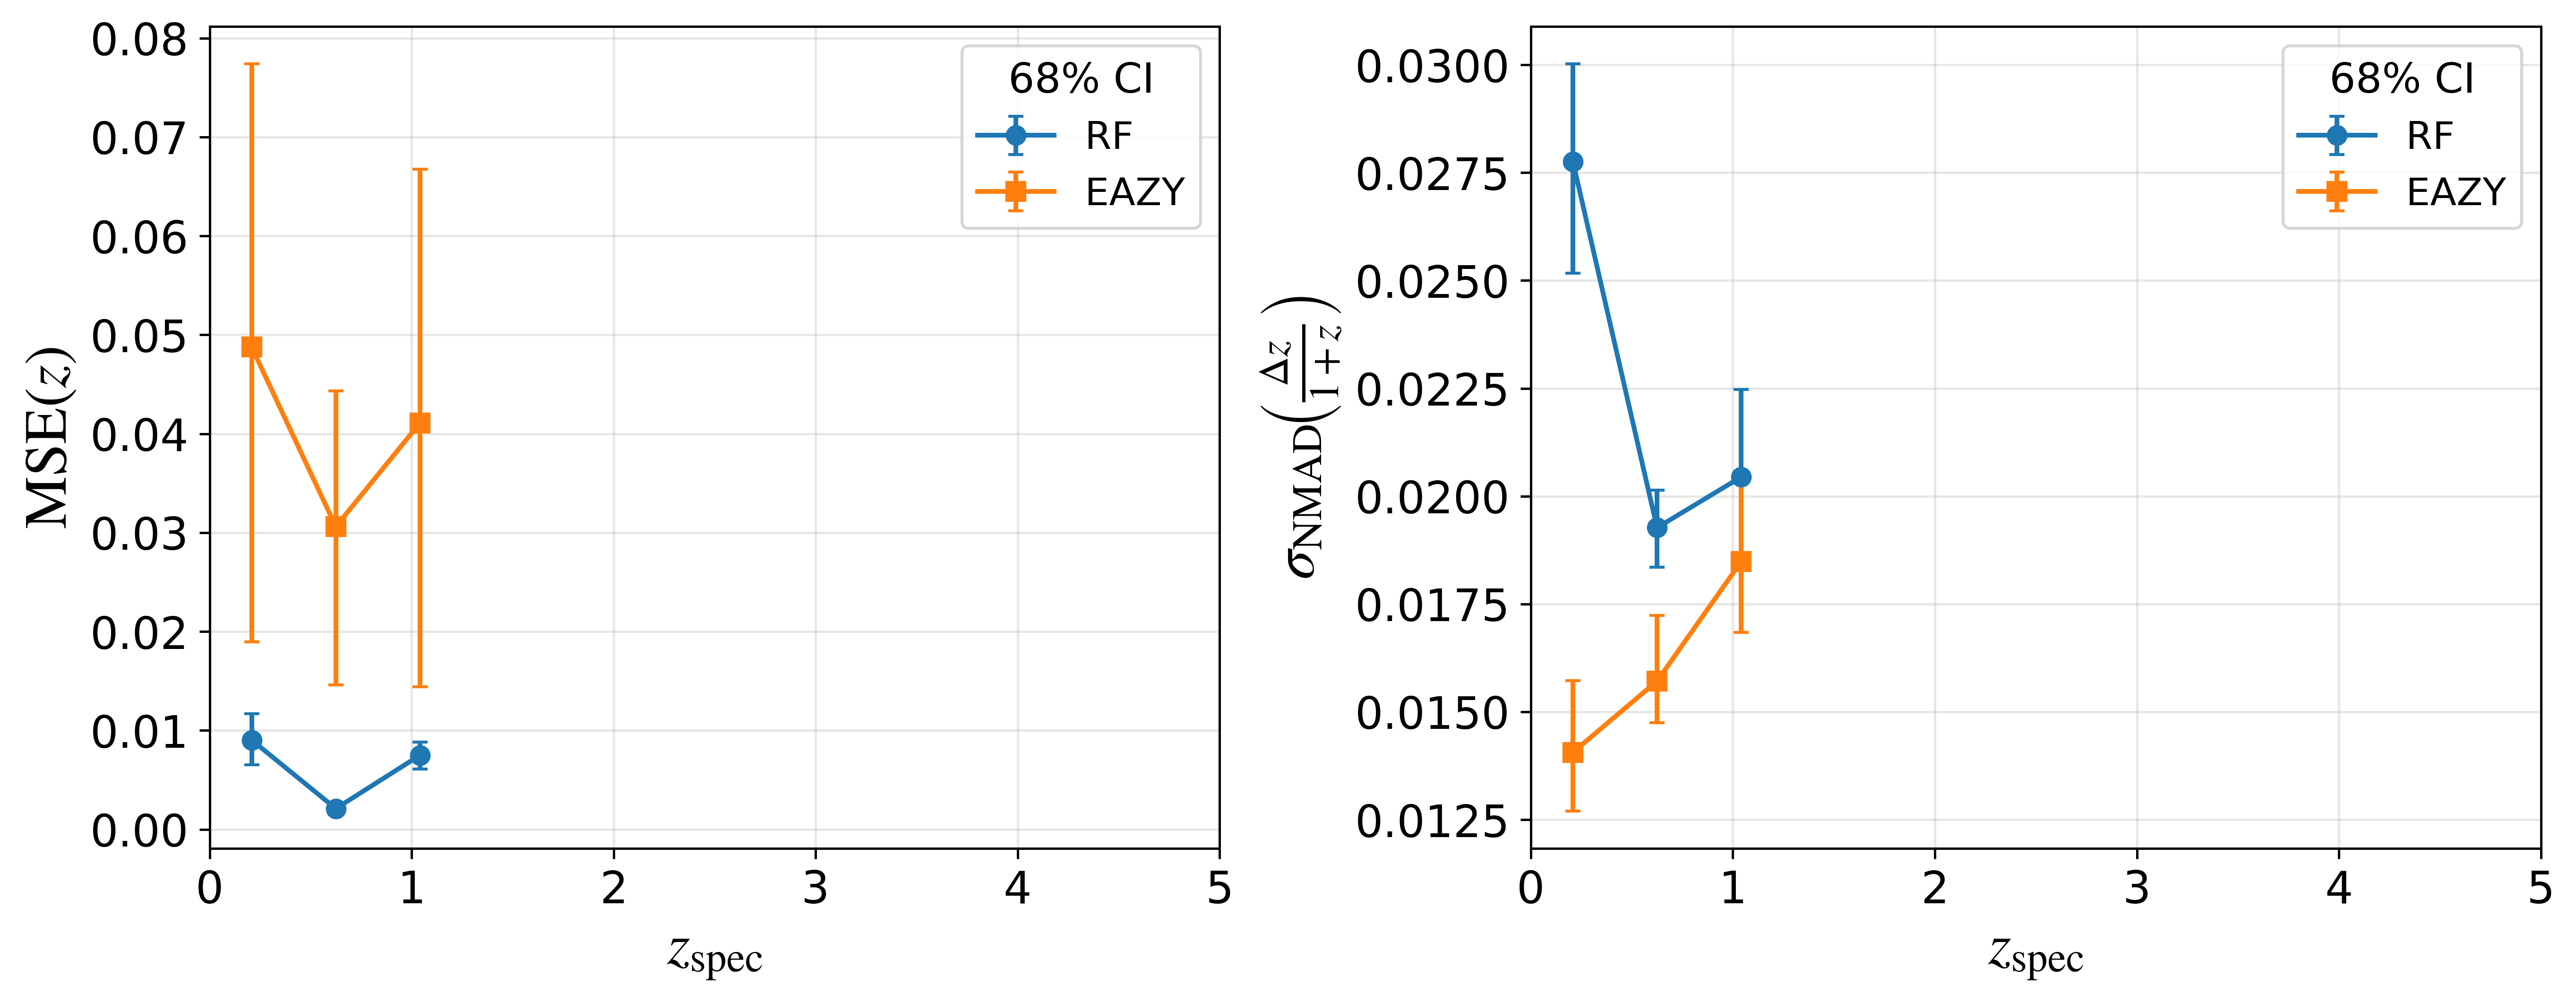

In [10]:
# -------------------------
# FIGURE 2 (with error bars): Binned performance vs. z_spec (global over all fields)
# -------------------------
import numpy as np
import matplotlib.pyplot as plt

# ===== Helper: bootstrap CI for an arbitrary statistic =====
def _bootstrap_ci(stat_fn, zspec_bin, zpred_bin, B=600, ci=0.68, random_state=42):
    """
    Returns (y, yerr_lower, yerr_upper) where y = stat_fn(zspec_bin, zpred_bin)
    and yerr_* are *asymmetric* errors from bootstrap percentiles.
    """
    rng = np.random.default_rng(random_state)
    # If too few points, return NaNs for errors
    if zspec_bin.size < 3:
        y = stat_fn(zspec_bin, zpred_bin)
        return y, np.nan, np.nan

    y = stat_fn(zspec_bin, zpred_bin)

    stats = []
    n = zspec_bin.size
    for _ in range(B):
        idx = rng.integers(0, n, n)
        stats.append(stat_fn(zspec_bin[idx], zpred_bin[idx]))
    stats = np.asarray(stats)

    alpha = (1.0 - ci) / 2.0
    lo, hi = np.nanpercentile(stats, [100*alpha, 100*(1-alpha)])

    # Asymmetric error bars:
    err_lo = y - lo
    err_hi = hi - y
    # Numerical safety (avoid negative/zero)
    err_lo = np.maximum(err_lo, 0.0)
    err_hi = np.maximum(err_hi, 0.0)
    return y, err_lo, err_hi

# ===== Helper: compute binned stats + bootstrap errors =====
def _binned_perf_with_error(zspec_all, zpred_all, nbins=12, zmin=0.0, zmax=5.0, B=600, ci=0.68):
    """
    For each bin in z_spec, compute:
      - MSE(z) with bootstrap CI
      - NMAD(Δz/(1+z)) with bootstrap CI
    Returns:
      centers, (mse, mse_lo, mse_hi), (nmad, nmad_lo, nmad_hi)
    """
    zspec = np.asarray(zspec_all)
    zpred = np.asarray(zpred_all)
    msk = np.isfinite(zspec) & np.isfinite(zpred)
    zspec = zspec[msk]; zpred = zpred[msk]

    edges = np.linspace(zmin, zmax, nbins+1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # Define stats
    def _mse_fn(zs, zp):
        if zs.size == 0:
            return np.nan
        return mean_squared_error(zs, zp)

    def _nmad_fn(zs, zp):
        if zs.size == 0:
            return np.nan
        dzn = (zp - zs) / (1.0 + zs)
        return nmad(dzn)

    # Allocate
    mse_y, mse_lo, mse_hi   = np.full(nbins, np.nan), np.full(nbins, np.nan), np.full(nbins, np.nan)
    nmad_y, nmad_lo, nmad_hi = np.full(nbins, np.nan), np.full(nbins, np.nan), np.full(nbins, np.nan)

    for i, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        m = (zspec >= lo) & (zspec < hi)
        zs_bin = zspec[m]; zp_bin = zpred[m]
        if zs_bin.size == 0:
            continue

        # MSE with bootstrap CI
        y, elo, ehi = _bootstrap_ci(_mse_fn, zs_bin, zp_bin, B=B, ci=ci, random_state=42+i)
        mse_y[i], mse_lo[i], mse_hi[i] = y, elo, ehi

        # NMAD with bootstrap CI
        y, elo, ehi = _bootstrap_ci(_nmad_fn, zs_bin, zp_bin, B=B, ci=ci, random_state=4242+i)
        nmad_y[i], nmad_lo[i], nmad_hi[i] = y, elo, ehi

    return centers, (mse_y, mse_lo, mse_hi), (nmad_y, nmad_lo, nmad_hi)

# ===== Config for this figure =====
ZMIN_BIN, ZMAX_BIN = 0.0, 5.0
NBINS = PLOT_BINS     # (already defined above)
BOOTSTRAPS = 600      # increase for smoother CI; 600 is a good trade-off
CI_LEVEL   = 0.68     # 68% ~ 1-sigma; use 0.95 for 95% if you prefer

# ===== Compute RF binned stats with error bars =====
cent_rf, (mse_rf, mse_rf_lo, mse_rf_hi), (nmad_rf, nmad_rf_lo, nmad_rf_hi) = _binned_perf_with_error(
    all_rf_zspec, all_rf_pred, nbins=NBINS, zmin=ZMIN_BIN, zmax=ZMAX_BIN, B=BOOTSTRAPS, ci=CI_LEVEL
)

# ===== Compute EAZY binned stats with error bars (if available) =====
if all_ez_zspec.size:
    cent_ez, (mse_ez, mse_ez_lo, mse_ez_hi), (nmad_ez, nmad_ez_lo, nmad_ez_hi) = _binned_perf_with_error(
        all_ez_zspec, all_ez_pred, nbins=NBINS, zmin=ZMIN_BIN, zmax=ZMAX_BIN, B=BOOTSTRAPS, ci=CI_LEVEL
    )
else:
    cent_ez = cent_rf
    nanarr = np.full_like(cent_rf, np.nan, dtype=float)
    mse_ez, mse_ez_lo, mse_ez_hi = nanarr, nanarr, nanarr
    nmad_ez, nmad_ez_lo, nmad_ez_hi = nanarr, nanarr, nanarr

# ===== Plot with error bars =====
fig2, (ax_mse, ax_nmad) = plt.subplots(
    1, 2, figsize=(12, 4.6), dpi=450, constrained_layout=True, sharex=True
)

# --- Panel A: MSE(z) vs. z_spec bins ---
ax_mse.errorbar(
    cent_rf, mse_rf, yerr=[mse_rf_lo, mse_rf_hi],
    fmt='o-', lw=1.6, capsize=2.5, label='RF'
)
if np.isfinite(mse_ez).any():
    ax_mse.errorbar(
        cent_ez, mse_ez, yerr=[mse_ez_lo, mse_ez_hi],
        fmt='s-', lw=1.6, capsize=2.5, label='EAZY'
    )
ax_mse.set_ylabel(r"$\mathrm{MSE}(z)$")
ax_mse.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_mse.grid(alpha=0.3)
ax_mse.legend(frameon=True, title=f"{int(CI_LEVEL*100)}% CI")

# --- Panel B: NMAD(Δz/(1+z)) vs. z_spec bins ---
ax_nmad.errorbar(
    cent_rf, nmad_rf, yerr=[nmad_rf_lo, nmad_rf_hi],
    fmt='o-', lw=1.6, capsize=2.5, label='RF'
)
if np.isfinite(nmad_ez).any():
    ax_nmad.errorbar(
        cent_ez, nmad_ez, yerr=[nmad_ez_lo, nmad_ez_hi],
        fmt='s-', lw=1.6, capsize=2.5, label='EAZY'
    )
ax_nmad.set_ylabel(r"$\sigma_{\mathrm{NMAD}}\!\left(\frac{\Delta z}{1+z}\right)$")
ax_nmad.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_nmad.grid(alpha=0.3)
ax_nmad.legend(frameon=True, title=f"{int(CI_LEVEL*100)}% CI")

# Cosmetic: consistent x-limits
ax_mse.set_xlim(ZMIN_BIN, ZMAX_BIN)
ax_nmad.set_xlim(ZMIN_BIN, ZMAX_BIN)

plt.show()


=== AEGIS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
AEGIS: RF MSE=0.00322  |  EAZY MSE=0.03518 (n_eazy=264)

=== COSMOS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
COSMOS: RF MSE=0.00254  |  EAZY MSE=0.00339 (n_eazy=126)

=== GOODS-S ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
GOODS-S: RF MSE=0.00463  |  EAZY MSE=0.06216 (n_eazy=234)

=== GOODS-N ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
GOODS-N: RF MSE=0.00622  |  EAZY MSE=0.03637 (n_eazy=359)

=== UDS ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
UDS: RF MSE=0.00899  |  EAZY MSE=0.00542 (n_eazy=37)


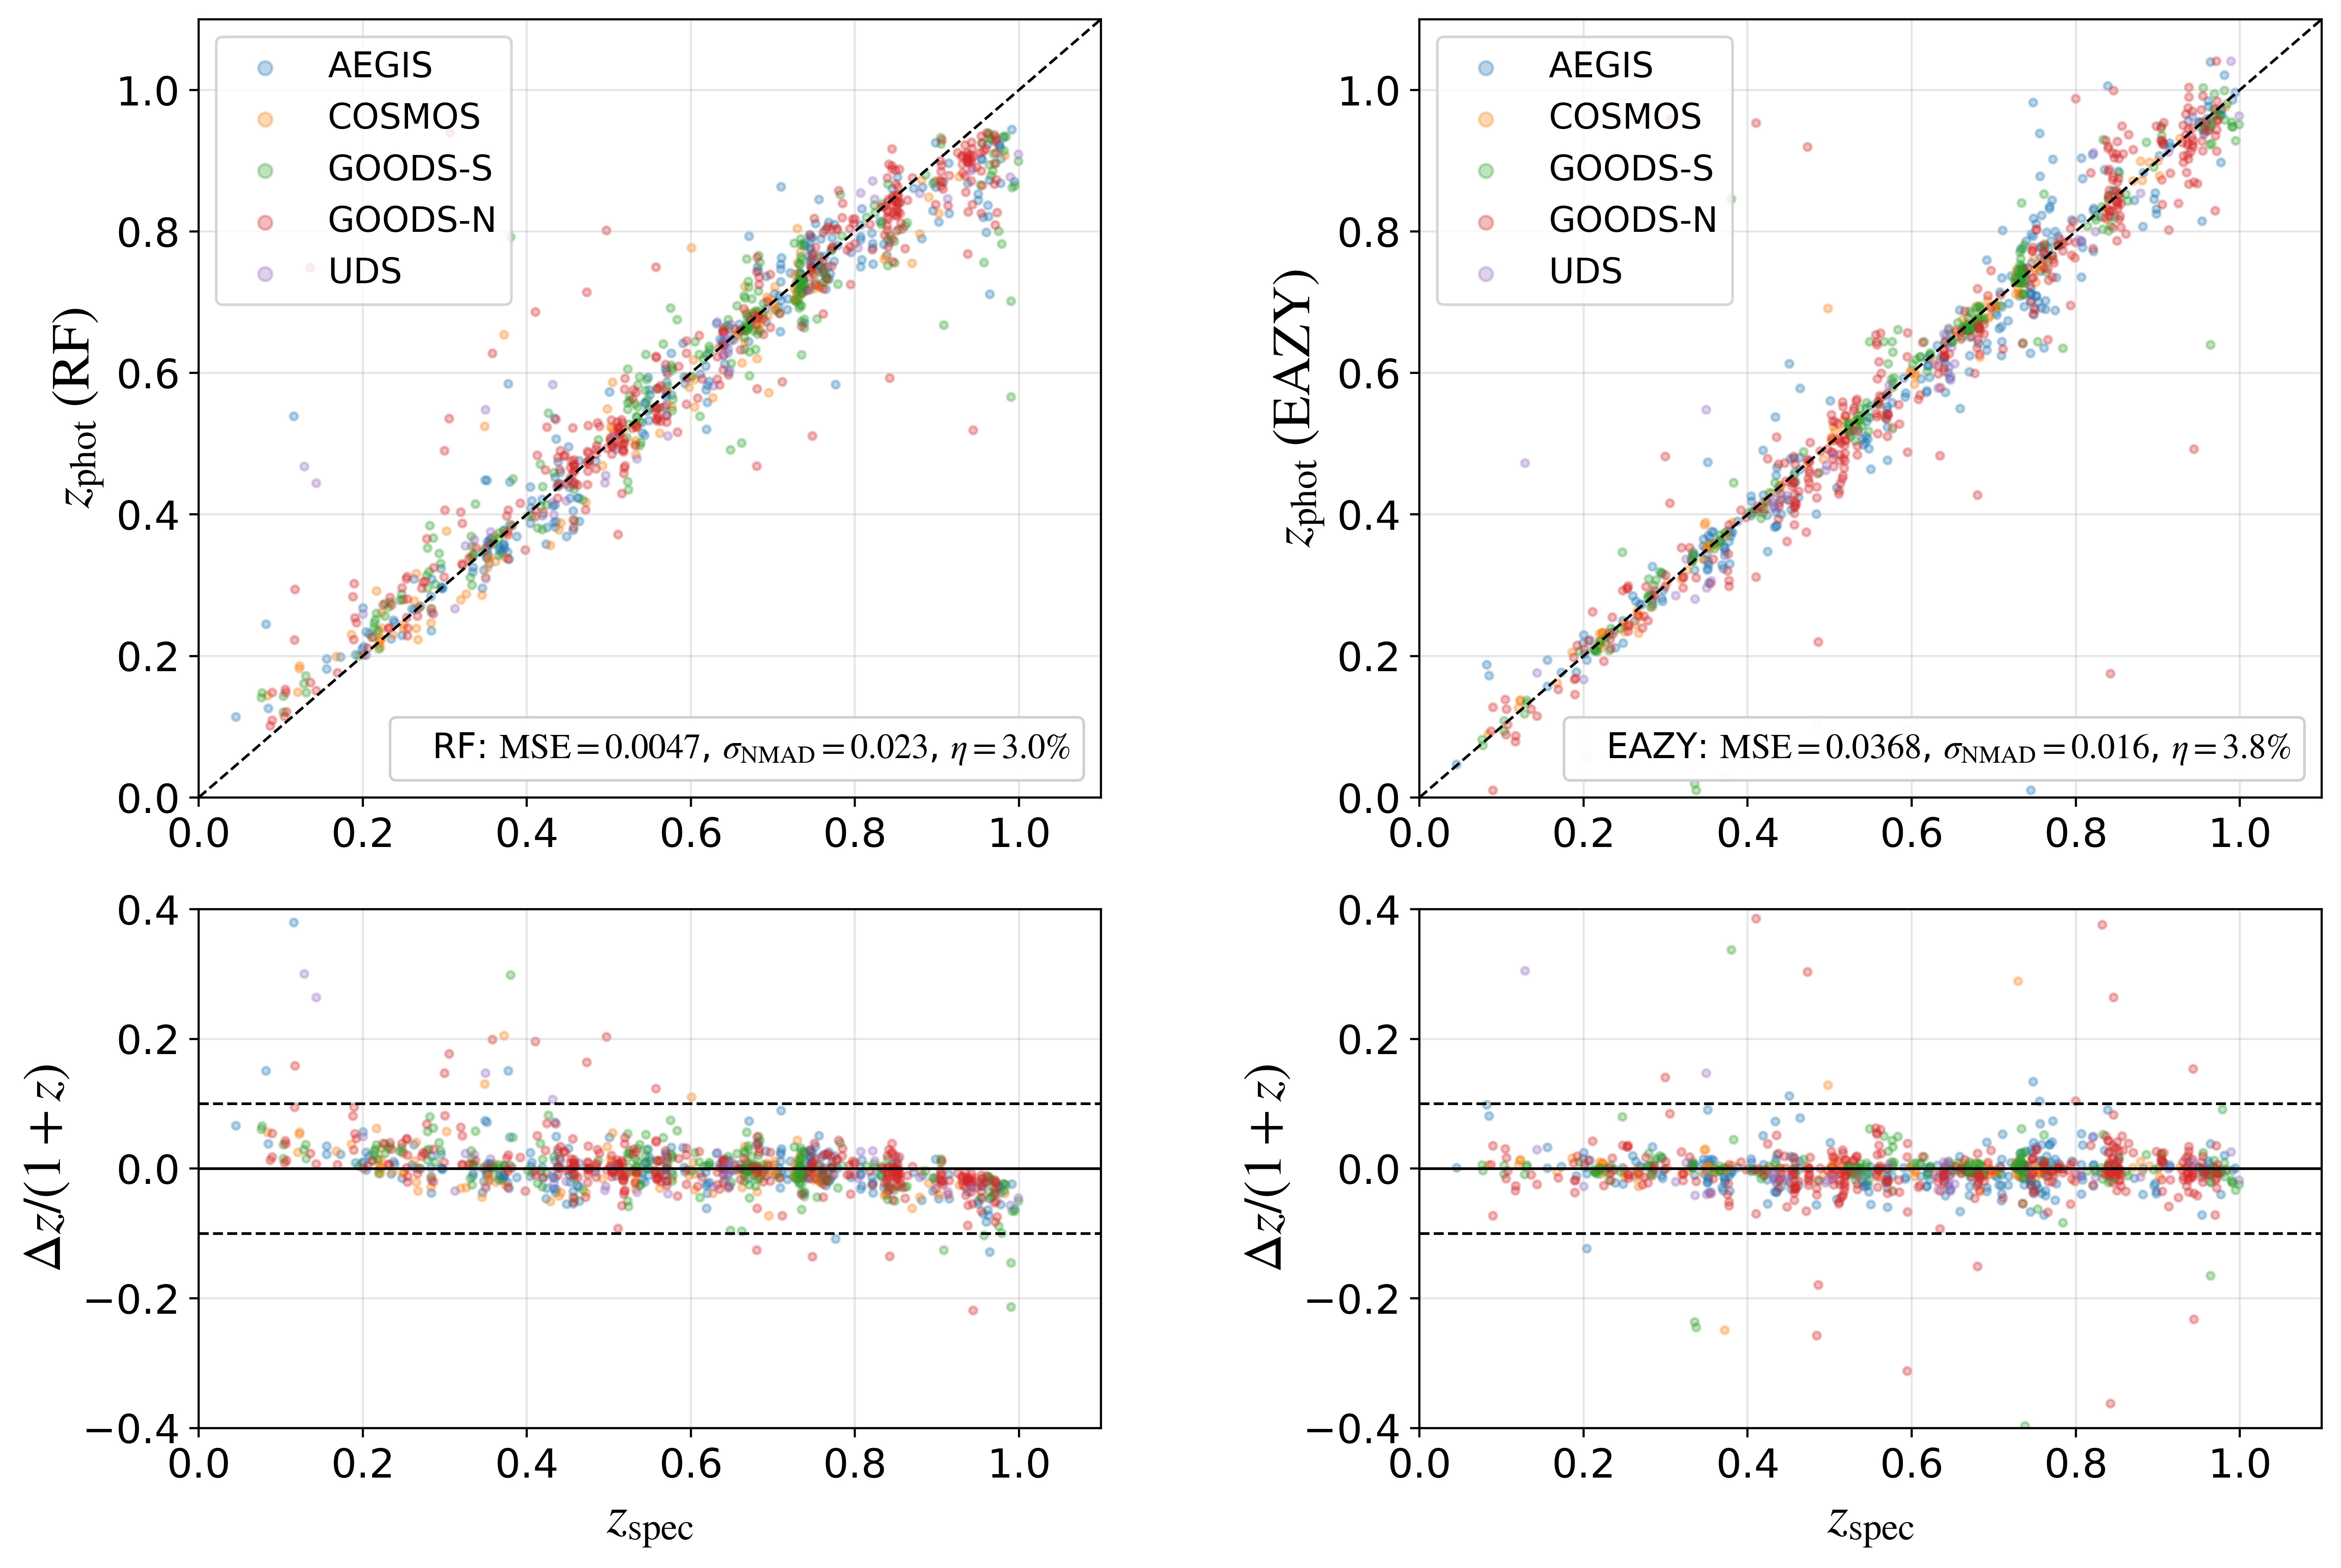


Per-field summary:
  field  n_test  mse_rf  mse_eazy  n_eazy
  AEGIS     264 0.00322   0.03518     264
 COSMOS     126 0.00254   0.00339     126
GOODS-N     359 0.00622   0.03637     359
GOODS-S     234 0.00463   0.06216     234
    UDS      37 0.00899   0.00542      37

Global (all fields, test sets combined):
RF   -> MSE(z)=0.00472, NMAD=0.0230, η=3.04%
EAZY -> MSE(z)=0.03678, NMAD=0.0162, η=3.82%
  field  n_test  mse_rf  mse_eazy  n_eazy
  AEGIS     264 0.00322   0.03518     264
 COSMOS     126 0.00254   0.00339     126
GOODS-N     359 0.00622   0.03637     359
GOODS-S     234 0.00463   0.06216     234
    UDS      37 0.00899   0.00542      37

Global (all fields, test sets combined):
RF   -> MSE(z)=0.00472, NMAD=0.0230, η=3.04%
EAZY -> MSE(z)=0.03678, NMAD=0.0162, η=3.82%


In [2]:

import os
import itertools
import numpy as np
import pandas as pd
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

# -------------------------
# Paths (EDIT THESE)
# -------------------------
BASE = "/Users/fengbocheng/Projects/Photometric-Redshifts"

FIELDS = {
    "AEGIS": {
        "cat":  f"{BASE}/aegis_3dhst.v4.1.cats/Catalog/aegis_3dhst.v4.1.cat",
        "zout": f"{BASE}/aegis_3dhst.v4.1.cats/Eazy/aegis_3dhst.v4.1.zout",
        "bands": [
            "U","G","F606W","R","I","F814W","Z",
            "F125W","J1","J2","J3","J","F140W","H1","H2","H","K","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "COSMOS": {
        "cat":  f"{BASE}/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat",
        "zout": f"{BASE}/cosmos_3dhst.v4.1.cats/Eazy/cosmos_3dhst.v4.1.zout",
        "bands": [
            "U","B","G","V","F606W","R","Rp","I","Ip","F814W","Z","Zp",
            "UVISTA_Y","F125W","J1","J2","J3","J","UVISTA_J","F140W",
            "H1","H2","H","UVISTA_H","K","Ks","UVISTA_Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "GOODS-S": {
        "cat":  f"{BASE}/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat",
        "zout": f"{BASE}/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout",
        "bands": [
            "U38","U","F435W","B","V","F606W","R","Rc","F775W","I","F814W","F850LP",
            "F125W","J","F140W","H","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "GOODS-N": {
        "cat":  f"{BASE}/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat",
        "zout": f"{BASE}/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout",
        "bands": [
            "U","F435W","B","G","V","F606W","R","Rs","I","F775W","Z","F850LP",
            "F125W","J","F140W","H","Ks",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
    "UDS": {
        "cat":  f"{BASE}/uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat",
        "zout": f"{BASE}/uds_3dhst.v4.2.cats/Eazy/uds_3dhst.v4.2.zout",
        "bands": [
            "u","B","V","F606W","R","i","F814W","z",
            "F125W","J","F140W","H","K",
            "IRAC1","IRAC2","IRAC3","IRAC4","F160W"
        ],
        "use_col": "use_phot"
    },
}

# -------------------------
# Config
# -------------------------
TARGET_COL        = "z_spec"
MAG_ZP            = 25.0
FLUX_FLOOR        = 1e-6
INCLUDE_COLORS    = True
N_BINS_STRAT      = 8  # for stratified split
PLOT_BINS         = 12 # for metric-vs-z plots
OUTLIER_THR       = 0.10  # |Δz|/(1+z) threshold

# Colors for plotting
PALETTE = {"AEGIS":"C0", "COSMOS":"C1", "GOODS-S":"C2", "GOODS-N":"C3", "UDS":"C4"}

# -------------------------
# Helpers
# -------------------------
def flux_to_mag(flux, zp=MAG_ZP):
    f = np.asarray(flux)
    f = np.where(np.isfinite(f) & (f > 0), f, np.nan)
    f = np.clip(f, FLUX_FLOOR, np.inf)
    return zp - 2.5*np.log10(f)

def build_features_in_bulk(tab: pd.DataFrame, bands: list, include_colors=True) -> pd.DataFrame:
    new_cols = {}
    # magnitudes
    for b in bands:
        fcol = f"f_{b}"
        if fcol in tab.columns:
            new_cols[f"mag_{b}"] = flux_to_mag(tab[fcol].to_numpy())
    # colors
    if include_colors:
        for a, b in itertools.combinations(bands, 2):
            ca, cb = f"mag_{a}", f"mag_{b}"
            if ca in new_cols and cb in new_cols:
                new_cols[f"color_{a}_{b}"] = new_cols[ca] - new_cols[cb]
            elif (ca in tab.columns) and (cb in tab.columns):
                new_cols[f"color_{a}_{b}"] = tab[ca] - tab[cb]
    # S/N
    for b in bands:
        f, e = f"f_{b}", f"e_{b}"
        if (f in tab.columns) and (e in tab.columns):
            earr = tab[e].to_numpy(); farr = tab[f].to_numpy()
            snr = np.where((earr > 0) & np.isfinite(earr) & np.isfinite(farr), farr / earr, np.nan)
            new_cols[f"snr_{b}"] = snr
    if new_cols:
        feat_df = pd.DataFrame(new_cols, index=tab.index)
        return pd.concat([tab, feat_df], axis=1).copy()
    return tab.copy()

def stratified_train_test_indices(y: np.ndarray, test_size=0.3, n_bins=10, seed=42):
    idx = np.where(np.isfinite(y))[0]
    yv = y[idx]
    q = np.quantile(yv, np.linspace(0, 1, n_bins+1))
    q = np.unique(q)
    if len(q) < 3:
        q = np.quantile(yv, np.linspace(0, 1, 6))
    bins = np.digitize(yv, q[1:-1], right=True)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    tr_rel, te_rel = next(sss.split(np.zeros_like(yv), bins))
    return idx[tr_rel], idx[te_rel]

def build_pipeline(feature_cols):
    preproc = ColumnTransformer(
        transformers=[("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ]), feature_cols)],
        remainder="drop",
    )
    rf = RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True, oob_score=False)
    pipe = Pipeline(steps=[("pre", preproc), ("rf", rf)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
    return model

def tuner():
    return {
        "regressor__rf__n_estimators": randint(300, 601),
        "regressor__rf__max_depth":    randint(6, 15),
        "regressor__rf__max_features": uniform(0.2, 0.6),
        "regressor__rf__min_samples_leaf": randint(1, 9),
        "regressor__rf__min_samples_split": randint(2, 21),
        "regressor__rf__max_samples":  uniform(0.6, 0.4),
    }

def nmad(delta):
    """NMAD of array (ignore NaNs)."""
    d = delta[np.isfinite(delta)]
    if d.size == 0:
        return np.nan
    med = np.median(d)
    return 1.4826 * np.median(np.abs(d - med))

def outlier_fraction(delta, thr=OUTLIER_THR):
    d = delta[np.isfinite(delta)]
    if d.size == 0:
        return np.nan
    return np.mean(np.abs(d) > thr)

def binned_metrics(zspec, zpred, nbins=12, zmin=None, zmax=None):
    """Return per-bin metrics: centers, MSE(z), NMAD(norm), outlier_frac(norm)."""
    zspec = np.asarray(zspec)
    zpred = np.asarray(zpred)
    mask = np.isfinite(zspec) & np.isfinite(zpred)
    zspec = zspec[mask]; zpred = zpred[mask]
    if zspec.size == 0:
        edges = np.linspace(0, 1, nbins+1)
        centers = 0.5*(edges[:-1]+edges[1:])
        arr = np.full(nbins, np.nan)
        return centers, arr, arr, arr

    if zmin is None: zmin = np.nanmin(zspec)
    if zmax is None: zmax = np.nanmax(zspec)
    edges = np.linspace(zmin, zmax, nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    mse_b, nmad_b, out_b = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (zspec >= lo) & (zspec < hi)
        if not np.any(m):
            mse_b.append(np.nan); nmad_b.append(np.nan); out_b.append(np.nan)
            continue
        dz   = zpred[m] - zspec[m]
        dzn  = dz / (1.0 + zspec[m])
        mse_b.append(mean_squared_error(zspec[m], zpred[m]))
        nmad_b.append(nmad(dzn))
        out_b.append(outlier_fraction(dzn, thr=OUTLIER_THR))
    return centers, np.array(mse_b), np.array(nmad_b), np.array(out_b)

from sklearn.metrics import make_scorer

def nmad_from_resid(d):
    d = d[np.isfinite(d)]
    if d.size == 0:
        return np.nan
    med = np.median(d)
    return 1.4826 * np.median(np.abs(d - med))

def nmad_scorer_func(y_true, y_pred):
    # normalized residuals
    dzn = (y_pred - y_true) / (1.0 + y_true)
    val = nmad_from_resid(dzn)
    # RandomizedSearchCV maximizes the score; return negative so "smaller NMAD is better"
    return -val if np.isfinite(val) else -1e9  # harsh penalty if undefined

NMAD_SCORER = make_scorer(nmad_scorer_func, greater_is_better=True)

# -------------------------
# Main loop over fields
# -------------------------
all_points_rf   = []  # (field, z_spec_test, z_pred_rf)
all_points_eazy = []  # (field, z_spec_test_for_ez, z_eazy_test)
metrics = []          # per-field numeric summary
all_rf_zspec, all_rf_pred = [], []
all_ez_zspec, all_ez_pred = [], []

for field_name, cfg in FIELDS.items():
    print(f"\n=== {field_name} ===")

    tab  = Table.read(cfg["cat"],  format="ascii").to_pandas()
    zout = Table.read(cfg["zout"], format="ascii").to_pandas()[["id", "z_peak"]]

    if "id" not in tab.columns:
        raise ValueError(f"{field_name}: photometric catalog missing 'id'.")
    tab = tab.merge(zout, on="id", how="left")

    use_col = cfg.get("use_col", "use_phot")
    if use_col in tab.columns:
        tab = tab[tab[use_col] == 1].copy()

    if TARGET_COL not in tab.columns:
        raise ValueError(f"{field_name}: missing {TARGET_COL}.")
    tab = tab[np.isfinite(tab[TARGET_COL]) & (tab[TARGET_COL] > 0) & (tab[TARGET_COL] <1)].copy()

    for b in cfg["bands"]:
        e = f"e_{b}"
        if e in tab.columns:
            bad = (~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90)
            tab.loc[bad, e] = np.nan

    tab = build_features_in_bulk(tab, cfg["bands"], include_colors=INCLUDE_COLORS)
    feature_cols = [c for c in tab.columns if c.startswith(("mag_", "color_", "snr_"))]

    y_all = tab[TARGET_COL].to_numpy()
    tr_idx, te_idx = stratified_train_test_indices(y_all, test_size=0.3, n_bins=N_BINS_STRAT, seed=42)
    X_train = tab.iloc[tr_idx][feature_cols]; y_train = y_all[tr_idx]
    X_test  = tab.iloc[te_idx][feature_cols]; y_test  = y_all[te_idx]

    model = build_pipeline(feature_cols)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=tuner(),
        n_iter=20, cv=3, scoring="neg_mean_squared_error",
        random_state=42, verbose=1,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    z_rf_test = best_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, z_rf_test)

    z_eazy_test = tab.iloc[te_idx]["z_peak"].to_numpy()
    mask_ez = np.isfinite(z_eazy_test)
    mse_ez = mean_squared_error(y_test[mask_ez], z_eazy_test[mask_ez]) if np.any(mask_ez) else np.nan

    print(f"{field_name}: RF MSE={mse_rf:.5f}  |  EAZY MSE={mse_ez:.5f} (n_eazy={mask_ez.sum()})")

    # collect for plotting & global metrics
    all_points_rf.append((field_name, y_test, z_rf_test))
    all_rf_zspec.append(y_test); all_rf_pred.append(z_rf_test)

    all_points_eazy.append((field_name, y_test[mask_ez], z_eazy_test[mask_ez]))
    if np.any(mask_ez):
        all_ez_zspec.append(y_test[mask_ez]); all_ez_pred.append(z_eazy_test[mask_ez])

    metrics.append({
        "field": field_name,
        "n_test": len(y_test),
        "mse_rf": mse_rf,
        "mse_eazy": mse_ez,
        "n_eazy": int(mask_ez.sum())
    })

# -------------------------
# Global metrics (for legend annotations)
# -------------------------
all_rf_zspec = np.concatenate(all_rf_zspec) if len(all_rf_zspec) else np.array([])
all_rf_pred  = np.concatenate(all_rf_pred)  if len(all_rf_pred)  else np.array([])
rf_dz_norm   = (all_rf_pred - all_rf_zspec) / (1.0 + all_rf_zspec)
RF_MSE   = mean_squared_error(all_rf_zspec, all_rf_pred) if all_rf_zspec.size else np.nan
RF_NMAD  = nmad(rf_dz_norm)
RF_ETA   = outlier_fraction(rf_dz_norm, thr=OUTLIER_THR)

if len(all_ez_zspec):
    all_ez_zspec = np.concatenate(all_ez_zspec)
    all_ez_pred  = np.concatenate(all_ez_pred)
    ez_dz_norm   = (all_ez_pred - all_ez_zspec) / (1.0 + all_ez_zspec)
    EZ_MSE  = mean_squared_error(all_ez_zspec, all_ez_pred)
    EZ_NMAD = nmad(ez_dz_norm)
    EZ_ETA  = outlier_fraction(ez_dz_norm, thr=OUTLIER_THR)
else:
    all_ez_zspec = np.array([]); all_ez_pred = np.array([])
    ez_dz_norm   = np.array([])
    EZ_MSE = EZ_NMAD = EZ_ETA = np.nan

# -------------------------
# FIGURE 1: Top (z_phot vs z_spec), Bottom (Δz/(1+z) vs z_spec), RF vs EAZY
# -------------------------
def apply_style(
    family="DejaVu Sans", math="stix", use_tex=False,
    base=15, label=20, title=18, tick=15, leg=13, leg_title=14
):
    plt.rcParams.update({
        "font.family": family,
        "font.size": base,
        "axes.labelsize": label,
        "axes.titlesize": title,
        "xtick.labelsize": tick,
        "ytick.labelsize": tick,
        "legend.fontsize": leg,
        "legend.title_fontsize": leg_title,
        "text.usetex": use_tex,
        "mathtext.fontset": math,
    })

apply_style() 

zmin, zmax = 0.0, 1.1
res_ylim   = (-0.4, 0.4)

fig = plt.figure(figsize=(12, 8), dpi=500, constrained_layout=True)
gs  = gridspec.GridSpec(
    nrows=2, ncols=2, figure=fig,
    height_ratios=[3, 2], wspace=0.12, hspace=0.05
)

# -- RF: top scatter and bottom residual (share x)
ax_rf_top = fig.add_subplot(gs[0, 0])
ax_rf_bot = fig.add_subplot(gs[1, 0], sharex=ax_rf_top)

# Top: identity line first, then points
ax_rf_top.plot([zmin, zmax], [zmin, zmax], color='k', ls='--', lw=1)
for field, z_spec_vec, z_rf_vec in all_points_rf:
    ax_rf_top.scatter(z_spec_vec, z_rf_vec, s=8, alpha=0.30, color=PALETTE[field], label=field)

ax_rf_top.set_xlim(zmin, zmax)
ax_rf_top.set_ylim(zmin, zmax)
ax_rf_top.grid(alpha=0.3)
ax_rf_top.set_ylabel(r"$z_{\mathrm{phot}}\;(\mathrm{RF})$")

# Legends: fields (UL) + metrics (LR)
handles, labels = ax_rf_top.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
leg_fields = ax_rf_top.legend(uniq.values(), uniq.keys(),
                              markerscale=1.8, frameon=True, loc="upper left")
ax_rf_top.add_artist(leg_fields)

rf_label = (rf"RF: $\mathrm{{MSE}}={RF_MSE:.4f}$, "
            rf"$\sigma_{{\mathrm{{NMAD}}}}={RF_NMAD:.3f}$, "
            rf"$\eta={100*RF_ETA:.1f}\%$")
leg_metrics = ax_rf_top.legend(
    [plt.Line2D([0],[0], ls='', color='k')],
    [rf_label], loc="lower right", frameon=True, handlelength=0
)
ax_rf_top.add_artist(leg_metrics)

# Bottom: normalized residuals
for field, z_spec_vec, z_rf_vec in all_points_rf:
    dzn = (z_rf_vec - z_spec_vec) / (1.0 + z_spec_vec)
    ax_rf_bot.scatter(z_spec_vec, dzn, s=8, alpha=0.3, color=PALETTE[field])

ax_rf_bot.axhline(0.0, color='k', lw=1, ls='-')
ax_rf_bot.axhline(+OUTLIER_THR, color='k', lw=1, ls='--')
ax_rf_bot.axhline(-OUTLIER_THR, color='k', lw=1, ls='--')
ax_rf_bot.set_ylim(res_ylim)
ax_rf_bot.grid(alpha=0.3)
ax_rf_bot.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_rf_bot.set_ylabel(r"$\Delta z/(1+z)$")

# -- EAZY: top scatter and bottom residual (share x & y with RF top)
ax_ez_top = fig.add_subplot(gs[0, 1], sharex=ax_rf_top, sharey=ax_rf_top)
ax_ez_bot = fig.add_subplot(gs[1, 1], sharex=ax_rf_top)

ax_ez_top.plot([zmin, zmax], [zmin, zmax], color='k', ls='--', lw=1)
for field, z_spec_vec, z_ez_vec in all_points_eazy:
    ax_ez_top.scatter(z_spec_vec, z_ez_vec, s=8, alpha=0.30, color=PALETTE[field], label=field)

ax_ez_top.set_xlim(zmin, zmax)
ax_ez_top.set_ylim(zmin, zmax)
ax_ez_top.grid(alpha=0.3)
ax_ez_top.set_ylabel(r"$z_{\mathrm{phot}}\;(\mathrm{EAZY})$")

handles2, labels2 = ax_ez_top.get_legend_handles_labels()
uniq2 = dict(zip(labels2, handles2))
leg_fields2 = ax_ez_top.legend(uniq2.values(), uniq2.keys(),
                               markerscale=1.8, frameon=True, loc="upper left")
ax_ez_top.add_artist(leg_fields2)

ez_label = (rf"EAZY: $\mathrm{{MSE}}={EZ_MSE:.4f}$, "
            rf"$\sigma_{{\mathrm{{NMAD}}}}={EZ_NMAD:.3f}$, "
            rf"$\eta={100*EZ_ETA:.1f}\%$")
leg_metrics2 = ax_ez_top.legend(
    [plt.Line2D([0],[0], ls='', color='k')],
    [ez_label], loc="lower right", frameon=True, handlelength=0
)
ax_ez_top.add_artist(leg_metrics2)

for field, z_spec_vec, z_ez_vec in all_points_eazy:
    dzn = (z_ez_vec - z_spec_vec) / (1.0 + z_spec_vec)
    ax_ez_bot.scatter(z_spec_vec, dzn, s=8, alpha=0.3, color=PALETTE[field])

ax_ez_bot.axhline(0.0, color='k', lw=1, ls='-')
ax_ez_bot.axhline(+OUTLIER_THR, color='k', lw=1, ls='--')
ax_ez_bot.axhline(-OUTLIER_THR, color='k', lw=1, ls='--')
ax_ez_bot.set_ylim(res_ylim)
ax_ez_bot.grid(alpha=0.3)
ax_ez_bot.set_xlabel(r"$z_{\mathrm{spec}}$")
ax_ez_bot.set_ylabel(r"$\Delta z/(1+z)$")

plt.show()

# -------------------------
# Print per-field table
# -------------------------
met_df = pd.DataFrame(metrics).sort_values("field")
print("\nPer-field summary:")
print(met_df.to_string(index=False, float_format=lambda x: f"{x:.5f}"))
print("\nGlobal (all fields, test sets combined):")
print(f"RF   -> MSE(z)={RF_MSE:.5f}, NMAD={RF_NMAD:.4f}, η={100*RF_ETA:.2f}%")
print(f"EAZY -> MSE(z)={EZ_MSE:.5f}, NMAD={EZ_NMAD:.4f}, η={100*EZ_ETA:.2f}%")
print(met_df.to_string(index=False, float_format=lambda x: f"{x:.5f}"))
print("\nGlobal (all fields, test sets combined):")
print(f"RF   -> MSE(z)={RF_MSE:.5f}, NMAD={RF_NMAD:.4f}, η={100*RF_ETA:.2f}%")
print(f"EAZY -> MSE(z)={EZ_MSE:.5f}, NMAD={EZ_NMAD:.4f}, η={100*EZ_ETA:.2f}%")

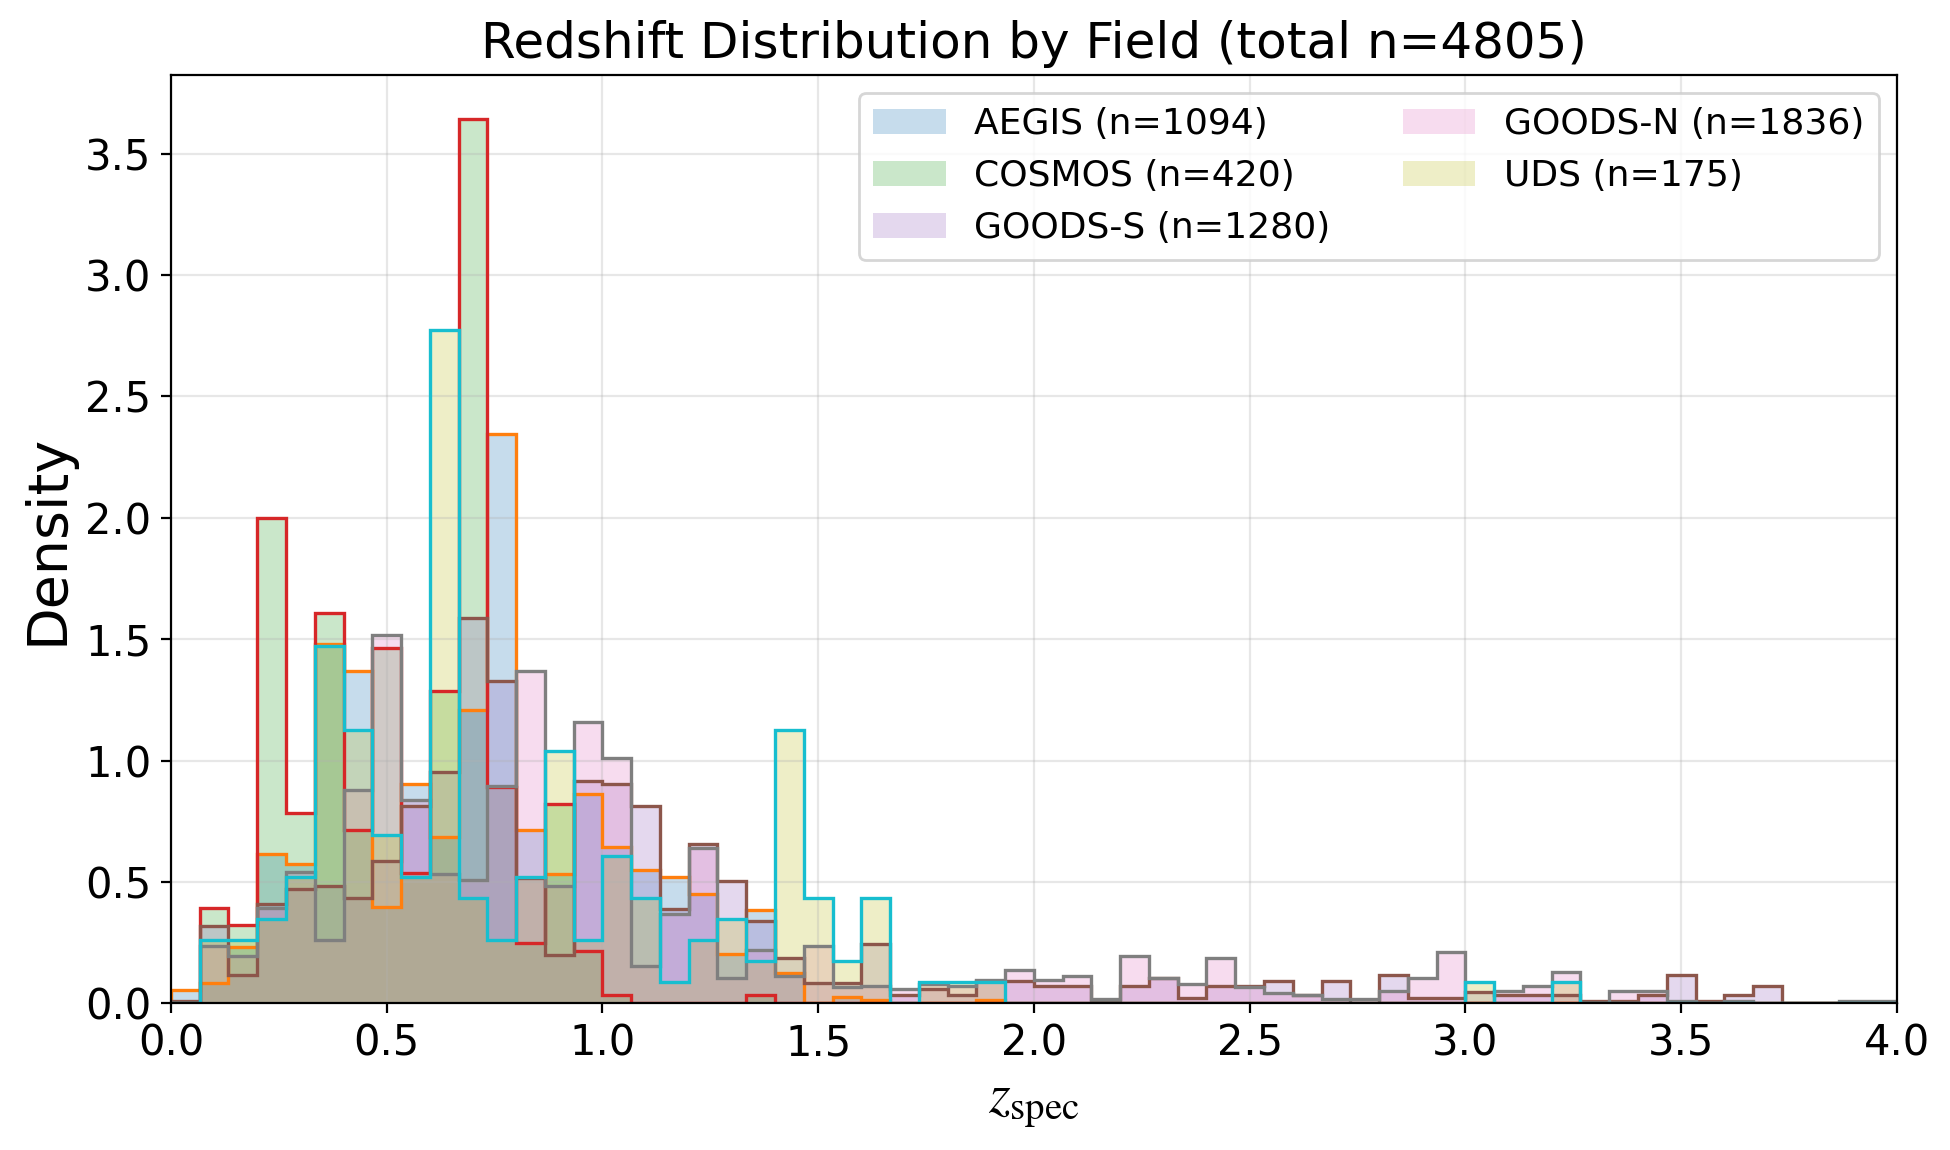

In [ ]:
# ==== Redshift distribution in one figure: overlaid ====
def plot_redshift_overlaid(fields_cfg, base_bins=60, zmin=0.0, zmax=5.0, density=True):
    # 保持与你的风格一致
    plt.rcParams.update({
        "font.size": 15, "axes.labelsize": 20, "axes.titlesize": 18,
        "xtick.labelsize": 15, "ytick.labelsize": 15, "legend.fontsize": 13
    })
    bins = np.linspace(zmin, zmax, base_bins+1)
    fig, ax = plt.subplots(figsize=(10,6), dpi=200)

    total_n = 0
    for field_name, cfg in fields_cfg.items():
        # 读数据并合并 EAZY（与主代码同逻辑）
        tab  = Table.read(cfg["cat"],  format="ascii").to_pandas()
        zout = Table.read(cfg["zout"], format="ascii").to_pandas()[["id", "z_peak"]]
        if "id" not in tab.columns:
            raise ValueError(f"{field_name}: photometric catalog missing 'id'.")
        tab = tab.merge(zout, on="id", how="left")
        use_col = cfg.get("use_col", "use_phot")
        if use_col in tab.columns:
            tab = tab[tab[use_col] == 1].copy()
        if TARGET_COL not in tab.columns:
            raise ValueError(f"{field_name}: missing {TARGET_COL}.")
        z = tab[TARGET_COL].to_numpy()
        z = z[np.isfinite(z) & (z>0)]  # 基本清洗
        total_n += z.size

        # 方法1：填充直方图（带透明度）
        ax.hist(z, bins=bins, histtype="stepfilled", alpha=0.25,
                label=f"{field_name} (n={z.size})", density=density)

        # 方法2（可选）：再叠一条阶梯线，轮廓更清晰
        ax.hist(z, bins=bins, histtype="step", linewidth=1.2, density=density)

    ax.set_xlim(zmin, zmax)
    ax.set_xlabel(r"$z_{\mathrm{spec}}$")
    ax.set_ylabel("Density" if density else "Count")
    ax.grid(alpha=0.3)
    ax.set_title(f"Redshift Distribution by Field (total n={total_n})")
    ax.legend(ncol=2, frameon=True)
    plt.tight_layout()
    plt.show()

# 调用：
plot_redshift_overlaid(FIELDS, base_bins=60, zmin=0.0, zmax=5.0, density=True)